## Data Preprocessing

In [0]:
from pyspark.sql.functions import to_date, col, count, when

csv_file_path = "/Volumes/studentproject_01_exploration/studentproject_01_schema/files/Job History 1.csv"

# Set the legacy time parser policy
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Read the CSV file into a Spark DataFrame
df_spark = spark.read.option("header", "true").csv(csv_file_path)
 
# Convert "Reporting Date" to date type
df_spark = df_spark.withColumn("Reporting Date", to_date(df_spark["Reporting Date"], "dd-MMM-yy"))

df_spark = df_spark.filter(df_spark["Employee Class"] == "Staff")

# Display the top ten rows of the Spark DataFrame
display(df_spark)

# Find the total number of rows
total_rows = df_spark.count()
print("Total number of rows:", total_rows)

# Find the number of people whose employee status is terminated
terminated_count = df_spark.filter(df_spark["Employee Status"] == "Terminated").count()
print("Number of people whose employee status is terminated:", terminated_count)

# Calculate the number of missing values for each column
missing_values = df_spark.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df_spark.columns
])

# Display the result
print("The number of missing values for each row:")
display(missing_values)

In [0]:
# # No employees from the list with a reporting date of 2024-04-01 have terminated that month

# # Step 1: Filter the DataFrame for the specific reporting date and employee status "Terminated"
# filtered_df = df_spark.filter(
#     (df_spark["Reporting Date"] == lit("2024-04-01")) & 
#     (df_spark["Employee Status"] == "Terminated")
# )

# # Step 2: Extract the Person IDs that match the above condition
# terminated_person_ids = filtered_df.select("Person ID").distinct()

# # Step 3: Check if these Person IDs have "Terminated" status in other reporting dates
# status_check_df = df_spark.join(
#     terminated_person_ids, 
#     on="Person ID", 
#     how="inner"
# ).filter(
#     (df_spark["Reporting Date"] != lit("2024-04-01")) & 
#     (df_spark["Employee Status"] == "Terminated")
# )

# # Step 4: Count the number of distinct Person IDs that satisfy the condition
# count_other_terminated = status_check_df.select("Person ID").distinct().count()

# # Step 5: Compare with the original list of terminated Person IDs to see if all exist
# all_exist = count_other_terminated == terminated_person_ids.count()

# # Return the result
# all_exist


In [0]:
# High cardinality of JH Position Title (externalCode)
# Count the number of occurrences for each JH Position Title (externalCode)
position_title_count = df_spark.groupBy("JH Position Title (externalCode)").count().orderBy(col("count").desc())

# Display the result
display(position_title_count)

### Terminated Employees

In [0]:
# df1 = df_spark.filter(df_spark["Person ID"] == 115441).orderBy("Reporting Date")
# display(df1)

In [0]:
from pyspark.sql import functions as F

# Filter the DataFrame for rows where Employee Status is 'Terminated'
terminated_df = df_spark.filter(F.col("Employee Status") == "Terminated")

# Count the total number of terminated employees
total_terminated_count = terminated_df.count()
print("Total number of terminated employees (duplicates):", total_terminated_count)

# Check for duplicate Person IDs
duplicate_person_ids = terminated_df.groupBy("Person ID").count().filter(F.col("count") > 1)

# Join the original DataFrame with the DataFrame containing duplicate Person IDs
# This will keep only the records for Person IDs that are duplicates
duplicates_df = terminated_df.join(duplicate_person_ids, on="Person ID")

# Sort the records by Person ID and Reporting Date (ascending order)
duplicates_df = duplicates_df.orderBy("Person ID", "Reporting Date")

# For each duplicate Person ID and Last Day of Service, keep only the first Reporting Date
distinct_duplicates_df = duplicates_df.groupBy("Person ID", "Last Day of Service").agg(F.first("Reporting Date").alias("Reporting Date"))

# Keep only the records with Person IDs, Last Day of Service, and Reporting Date that match the distinct duplicates DataFrame
final_terminated_df = terminated_df.join(distinct_duplicates_df, on=["Person ID", "Last Day of Service", "Reporting Date"], how="inner")

total_final_terminated_count = final_terminated_df.count()
print("Total number of terminated employees:", total_final_terminated_count)

display(final_terminated_df.limit(10))

# # Group by Person ID and count the number of records for each Person ID
# person_id_count_df = final_df.groupBy("Person ID").count()

# # Filter out Person IDs where the count is greater than 1, indicating duplicates
# duplicate_person_ids_df = person_id_count_df.filter(F.col("count") > 1)

# # Join final_df with the DataFrame containing duplicate Person IDs to get all records with duplicate Person IDs
# duplicate_records_df = final_df.join(duplicate_person_ids_df, on="Person ID", how="inner")

# # Display the records with duplicate Person IDs
# display(duplicate_records_df)


# # Display the count in Sub Termination Reason (externalCode) and sort by count
# termination_reason_count = final_terminated_df.groupBy("Sub Termination Reason (externalCode)", "Sub Termination Reason (Label)").count().orderBy(col("count").desc())

# # Display the result
# display(termination_reason_count)

### Merge Tables (Supervisor ID)

In [0]:
# Delete the employees whose employee status is 'Terminated' from df_spark
df_cal = df_spark.filter(df_spark["Employee Status"] == "Active")

count_1 = df_cal.count()
# Add the final_terminated_df to df_spark
df_cal = df_cal.unionByName(final_terminated_df)

count_2 = df_cal.count()
print(count_1, count_2)
# Display the updated DataFrame
display(df_cal)

In [0]:
from pyspark.sql.functions import when

# Replace 'O', 'U', 'D', and null values in the 'Gender' column with 'O'
df_cal = df_cal.withColumn("Gender", when(col("Gender").isin("O", "U", "D") | col("Gender").isNull(), "O").otherwise(col("Gender")))

# Group by the 'Gender' column and count the number of occurrences of each gender
gender_count_df = df_cal.groupBy("Gender").count()

# Display the result
display(gender_count_df)

Gender count F 77992 M 181793 O 2025

In [0]:
csv_file_path = "/Volumes/studentproject_01_exploration/studentproject_01_schema/files/Job History Manager Change.csv"

# Read the CSV file into a Spark DataFrame
df_manager_spark = spark.read.option("header", "true").csv(csv_file_path)

In [0]:
from pyspark.sql.functions import to_date, col, row_number
from pyspark.sql.window import Window

# Convert "Event Date" and "Event Month" to date type
df_manager_spark = df_manager_spark.withColumn(
    "Event Date", 
    to_date(col("Event Date"), "dd/MM/yyyy")
)
df_manager_spark = df_manager_spark.withColumn(
    "Event Month", 
    to_date(col("Event Month"), "dd/MM/yyyy")
)

# Step 1: Filter df_manager_spark to retain rows with NO_MANAGER or supervisor id existing in df_cal's Person ID
person_ids = [row["Person ID"] for row in df_cal.select("Person ID").distinct().collect()]
filtered_df_manager_spark = df_manager_spark.filter(df_manager_spark["Person ID"].isin(person_ids))


filtered_df_manager_spark = df_manager_spark.filter(
    (df_manager_spark["Supervisor ID"] == "NO_MANAGER") | 
    (df_manager_spark["Supervisor ID"].isin(person_ids))
)

# Display the resulting DataFrame
display(filtered_df_manager_spark)

In [0]:
no_manager_df = filtered_df_manager_spark.filter(col("Supervisor ID") == "NO_MANAGER")
print(no_manager_df.count())
display(no_manager_df)

In [0]:
from pyspark.sql.functions import col, row_number
from pyspark.sql.window import Window

# Join df_cal with df_manager_spark on Person ID
df_joined = df_cal.join(filtered_df_manager_spark, df_cal["Person ID"] == filtered_df_manager_spark["Person ID"], "left")

# Define the window specification to partition by Person ID and Reporting Date, and order by Event Date descending
window_spec = Window.partitionBy(df_cal["Person ID"], df_cal["Reporting Date"]) \
                    .orderBy(filtered_df_manager_spark["Event Date"].desc())

# Filter to get the most recent event date before the reporting date for each person
df_filtered = df_joined.filter(filtered_df_manager_spark["Event Date"] <= df_cal["Reporting Date"]) \
                       .withColumn("Rank", row_number().over(window_spec)) \
                       .filter(col("Rank") == 1) \
                       .drop("Rank")

# Select the required columns
df_result = df_filtered.select(df_cal["*"], filtered_df_manager_spark["Supervisor ID"])

# Display the resulting DataFrame
display(df_result)


### Identify the active supervisor and their terminated employees

In [0]:
from pyspark.sql.functions import col

# Store Person ID whose Reporting Date is 2024-04-01 in supervisor_new
supervisor_new = df_result.filter(col("Reporting Date") == "2024-04-01").select("Person ID")

# Check if Supervisor ID is in supervisor_new and Employee status is Terminated
df_supervisor_new = df_result.filter(
    (col("Supervisor ID").isin([row["Person ID"] for row in supervisor_new.collect()])) &
    (col("Employee status") == "Terminated")
)

# Display the resulting DataFrame and the count of unique Supervisor IDs
display(df_supervisor_new)


In [0]:
# Find the number of unique Supervisor ID in df_supervisor_new
unique_supervisor_count = df_supervisor_new.select("Supervisor ID").distinct().count()
display(spark.createDataFrame([(unique_supervisor_count,)], ["Unique Supervisor Count"]))

Unique Supervisor Count 694

### Calculate monthly turnover rate

In [0]:
df_cal = df_result.select("*")

In [0]:
# from pyspark.sql.functions import col

# filtered_df = filtered_df_manager_spark.filter(col("Person ID") == 110071)
# display(filtered_df)

In [0]:
# display(filtered_df_manager_spark.filter(col("Person ID") == 8129))
# display(df_result.filter(col("Person ID") == 8129))

In [0]:
from pyspark.sql.functions import count

# Count the number of persons in each Reporting Date
reporting_date_counts = df_cal.groupBy("Reporting Date").agg(count("Person ID").alias("Person Count"))

# Display the result
display(reporting_date_counts)

Reporting Date Person Count 2022-07-31 3793 2020-04-30 3685 2022-01-31 3758 2019-02-28 3354 2024-03-31 4368 2023-07-31 4170 2019-09-30 3517 2021-09-30 3706 2021-05-31 3707 2023-12-31 4306 2022-02-28 3743 2023-06-30 4116 2024-02-29 4361 2018-12-31 3054 2019-08-31 3484 2019-01-31 3176 2019-06-30 3431 2021-07-31 3711 2024-04-01 4320 2020-07-31 3584 2021-04-30 3687 2019-07-31 3445 2023-10-31 4280 2023-09-30 4232 2024-01-31 4324 2021-10-31 3726 2022-04-30 3786 2023-01-31 3858 2020-12-31 3584 2018-11-30 3048 2023-08-31 4187 2019-05-31 3422 2019-10-31 3543 2020-02-29 3696 2019-04-30 3401 2022-09-30 3854 2021-01-31 3601 2023-04-30 4016 2020-03-31 3699 2018-10-31 2998 2023-05-31 4064 2022-03-31 3775 2020-09-30 3561 2020-01-31 3651 2023-02-28 3910 2023-11-30 4311 2022-05-31 3775 2023-03-31 3947 2019-11-30 3586 2021-06-30 3706 2020-10-31 3587 2021-12-31 3724 2021-08-31 3706 2020-05-31 3668 2021-11-30 3759 2021-03-31 3660 2019-12-31 3580 2022-06-30 3759 2021-02-28 3634 2020-11-30 3592 2019-03-31 3378 2022-11-30 3844 2020-08-31 3552 2022-12-31 3827 2022-10-31 3847 2020-06-30 3630 2022-08-31 3814

Reporting Date Total Count Terminated Count Turnover Rate 2018-10-31 2998 28 0.009339559706470981 2018-11-30 3048 51 0.01673228346456693 2018-12-31 3054 44 0.014407334643091027 2019-01-31 3176 44 0.013853904282115869 2019-02-28 3354 57 0.01699463327370304 2019-03-31 3378 63 0.018650088809946713 2019-04-30 3401 48 0.014113496030579242 2019-05-31 3422 48 0.014026884862653419 2019-06-30 3431 69 0.020110754881958612 2019-07-31 3445 41 0.011901306240928883 2019-08-31 3484 55 0.01578645235361653 2019-09-30 3517 52 0.014785328404890531 2019-10-31 3543 45 0.012701100762066046 2019-11-30 3586 63 0.017568321249302844 2019-12-31 3580 40 0.0111731843575419 2020-01-31 3651 61 0.016707751301013422 2020-02-29 3696 68 0.0183982683982684 2020-03-31 3699 52 0.014057853473911868 2020-04-30 3685 47 0.012754409769335142 2020-05-31 3668 63 0.01717557251908397 2020-06-30 3630 109 0.03002754820936639 2020-07-31 3584 82 0.022879464285714284 2020-08-31 3552 51 0.014358108108108109 2020-09-30 3561 40 0.011232799775344004 2020-10-31 3587 71 0.019793699470309453 2020-11-30 3592 46 0.012806236080178173 2020-12-31 3584 71 0.019810267857142856 2021-01-31 3601 66 0.018328242154956955 2021-02-28 3634 77 0.021188772702256466 2021-03-31 3660 58 0.015846994535519125 2021-04-30 3687 58 0.015730946569026308 2021-05-31 3707 82 0.022120312921499866 2021-06-30 3706 78 0.021046950890447922 2021-07-31 3711 91 0.024521692266235517 2021-08-31 3706 70 0.018888289260658393 2021-09-30 3706 60 0.016189962223421478 2021-10-31 3726 87 0.023349436392914653 2021-11-30 3759 67 0.01782388933226922 2021-12-31 3724 69 0.01852846401718582 2022-01-31 3758 138 0.036721660457690264 2022-02-28 3743 62 0.016564253272775848 2022-03-31 3775 81 0.021456953642384105 2022-04-30 3786 98 0.025884838880084523 2022-05-31 3775 92 0.024370860927152318 2022-06-30 3759 70 0.0186219739292365 2022-07-31 3793 89 0.023464276298444504 2022-08-31 3814 62 0.016255899318300997 2022-09-30 3854 88 0.022833419823559936 2022-10-31 3847 90 0.02339485313231089 2022-11-30 3844 56 0.014568158168574402 2022-12-31 3827 78 0.02038149986934936 2023-01-31 3858 71 0.0184033177812338 2023-02-28 3910 62 0.015856777493606138 2023-03-31 3947 83 0.02102862933873828 2023-04-30 4016 82 0.02041832669322709 2023-05-31 4064 53 0.013041338582677165 2023-06-30 4116 60 0.014577259475218658 2023-07-31 4170 63 0.015107913669064749 2023-08-31 4187 51 0.012180558872701218 2023-09-30 4232 67 0.015831758034026464 2023-10-31 4280 49 0.011448598130841122 2023-11-30 4311 55 0.012758060774762237 2023-12-31 4306 56 0.013005109150023224 2024-01-31 4324 47 0.010869565217391304 2024-02-29 4361 61 0.013987617518917679 2024-03-31 4368 49 0.011217948717948718 2024-04-01 4320 null null

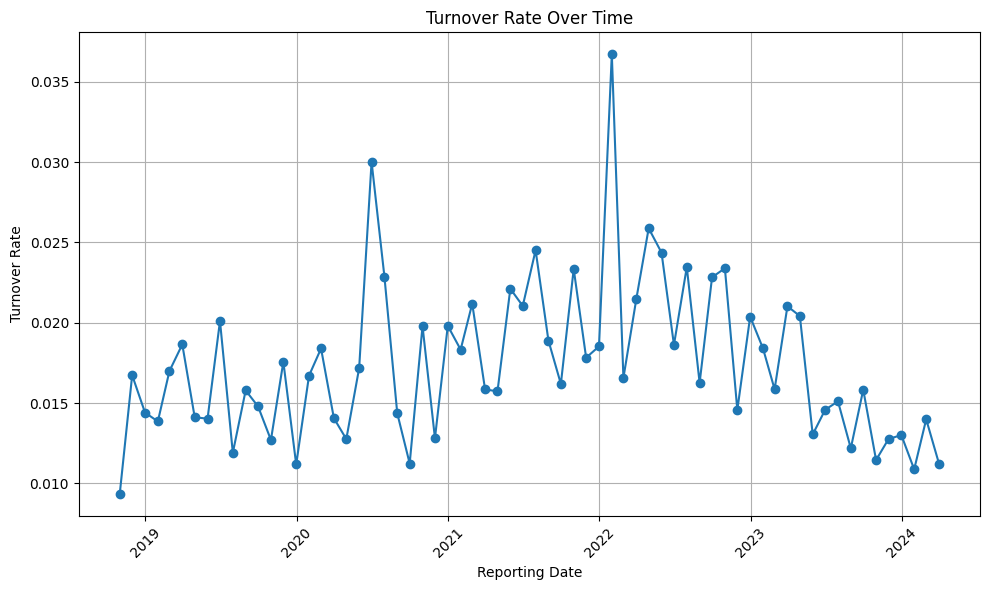

In [0]:
from pyspark.sql.functions import count, col
import matplotlib.pyplot as plt

# Calculate the total number of employees for each reporting date
total_counts = df_cal.groupBy("Reporting Date").agg(count("Person ID").alias("Total Count"))

# Calculate the number of terminated employees for each reporting date
terminated_counts = df_cal.filter(col("Employee Status") == "Terminated")\
    .groupBy("Reporting Date").agg(count("Person ID").alias("Terminated Count"))

# Join total counts with terminated counts on the reporting date
joined_counts = total_counts.join(terminated_counts, "Reporting Date", "left")

# Calculate the turnover rate (Turnover Rate = Terminated Count / Total Count)
joined_counts = joined_counts.withColumn("Turnover Rate", col("Terminated Count") / col("Total Count"))

# Order the results by Reporting Date in ascending order
ordered_counts = joined_counts.orderBy("Reporting Date")

# Display the result
display(ordered_counts)

# Convert to Pandas DataFrame for plotting
ordered_counts_pd = ordered_counts.toPandas()

# Plot the turnover rate over time
plt.figure(figsize=(10, 6))
plt.plot(ordered_counts_pd["Reporting Date"], ordered_counts_pd["Turnover Rate"], marker='o')
plt.title("Turnover Rate Over Time")
plt.xlabel("Reporting Date")
plt.ylabel("Turnover Rate")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Year Total Count Terminated Count Turnover Rate 2018 9100 123 0.013516483516483517 2019 41317 625 0.015126945325168817 2020 43489 761 0.017498677826576835 2021 44327 863 0.01946894669163264 2022 45575 1004 0.022029621503017006 2023 49397 752 0.015223596574690771 2024 17373 157 0.00903701145455592

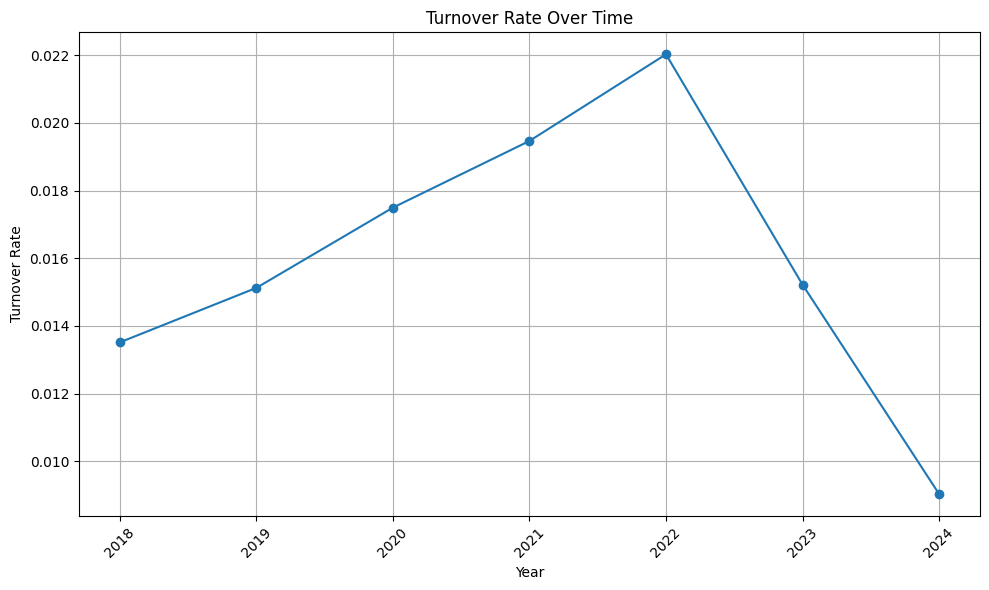

In [0]:
from pyspark.sql.functions import count, col, year
import matplotlib.pyplot as plt

# Calculate the total number of employees for each year
total_counts = df_cal.groupBy(year("Reporting Date").alias("Year")).agg(count("Person ID").alias("Total Count"))

# Calculate the number of terminated employees for each year
terminated_counts = df_cal.filter(col("Employee Status") == "Terminated")\
    .groupBy(year("Reporting Date").alias("Year")).agg(count("Person ID").alias("Terminated Count"))

# Join total counts with terminated counts on the year
joined_counts = total_counts.join(terminated_counts, on="Year", how="left")

# Calculate the turnover rate (Turnover Rate = Terminated Count / Total Count)
joined_counts = joined_counts.withColumn("Turnover Rate", col("Terminated Count") / col("Total Count"))

# Order the results by Year in ascending order
ordered_counts = joined_counts.orderBy("Year")

# Display the result
display(ordered_counts)

# Convert to Pandas DataFrame for plotting
ordered_counts_pd = ordered_counts.toPandas()

# Plot the turnover rate over time
plt.figure(figsize=(10, 6))
plt.plot(ordered_counts_pd["Year"], ordered_counts_pd["Turnover Rate"], marker='o')
plt.title("Turnover Rate Over Time")
plt.xlabel("Year")
plt.ylabel("Turnover Rate")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [0]:
# from pyspark.sql.functions import count, col, when

# # Replace specific BU values with 'Corporate'
# values_to_replace = ['Customer & Corp Affairs', 'Chief Operations Office', 'Commercial', 'Executive Management', 'Finance & Group Services', 'HSE', 'ICT', 'People', 'Strategy', 'WA Region']
# df_cal = df_cal.withColumn("BU", when(col("BU").isin(values_to_replace), "Corporate").otherwise(col("BU")))

# # Count the number of employees in each Business Unit (BU)
# bu_counts = df_cal.groupBy("BU").agg(count("Person ID").alias("Employee Count"))

# # Display the result
# display(bu_counts)

In [0]:
from pyspark.sql.functions import count, col, year

def calculate_turnover_rate_by_year(df, category_cols):
    """
    Calculate the turnover rate by year and specified category columns.

    Parameters:
    df (DataFrame): The input DataFrame containing employee data with columns
                    'Reporting Date', category columns, and 'Employee Status'.
    category_cols (str or list of str): The column name or list of column names to group by 
                                        (e.g., 'Gender' or ['Gender', 'BU']).

    Returns:
    DataFrame: A DataFrame with columns 'Year', category columns, 'Total Count', 
               'Terminated Count', and 'Turnover Rate' sorted by 'Year' and category columns.
    """
    # Ensure category_cols is a list
    if isinstance(category_cols, str):
        category_cols = [category_cols]  # Convert single column name to list
    elif not isinstance(category_cols, list):
        raise ValueError("category_cols should be a string or a list of column names.")
    
    # Calculate the total number of employees for each category in each year
    total_counts = df.groupBy(year("Reporting Date").alias("Year"), *category_cols) \
        .agg(count("Person ID").alias("Total Count"))

    # Calculate the number of terminated employees for each category in each year
    terminated_counts = df.filter(col("Employee Status") == "Terminated") \
        .groupBy(year("Reporting Date").alias("Year"), *category_cols) \
        .agg(count("Person ID").alias("Terminated Count"))

    # Join total counts with terminated counts on the year and category columns
    joined_counts = total_counts.join(terminated_counts, on=["Year"] + category_cols, how="left")

    # Calculate the turnover rate (Turnover Rate = Terminated Count / Total Count)
    joined_counts = joined_counts.withColumn("Turnover Rate", col("Terminated Count") / col("Total Count"))

    # Order the results by Year and category columns in ascending order
    ordered_counts = joined_counts.orderBy(["Year"] + category_cols)

    return ordered_counts



In [0]:
# Calculate turnover rate by 'Gender'
result_df = calculate_turnover_rate_by_year(df_cal, "Gender")
display(result_df)

Year Gender Total Count Terminated Count Turnover Rate 2018 F 2450 38 0.015510204081632653 2018 M 6645 85 0.012791572610985704 2018 O 5 null null 2019 F 11557 166 0.014363589166738773 2019 M 29730 457 0.015371678439286916 2019 O 30 2 0.06666666666666667 2020 F 12668 212 0.01673508051784023 2020 M 30677 549 0.01789614369071291 2020 O 144 null null 2021 F 13333 244 0.018300457511437787 2021 M 30496 612 0.020068205666316893 2021 O 498 7 0.014056224899598393 2022 F 13790 315 0.02284263959390863 2022 M 31279 674 0.021548003452795804 2022 O 506 15 0.029644268774703556 2023 F 15236 208 0.013651877133105802 2023 M 33633 539 0.016025926917016025 2023 O 528 5 0.00946969696969697 2024 F 5455 34 0.006232813932172319 2024 M 11718 120 0.010240655401945725 2024 O 200 3 0.015

In [0]:
# Calculate turnover rate by 'BU'
result_df = calculate_turnover_rate_by_year(df_cal, "BU")
display(result_df)

Year BU Total Count Terminated Count Turnover Rate 2018 Building 945 19 0.020105820105820106 2018 Commercial 46 null null 2018 Customer & Corp Affairs 15 null null 2018 D&I 68 null null 2018 Finance & Group Services 121 1 0.008264462809917356 2018 HSE 23 null null 2018 Infrastructure 5676 81 0.01427061310782241 2018 People 215 4 0.018604651162790697 2018 Rail 1516 14 0.009234828496042216 2018 Strategy 6 null null 2018 TEK 356 3 0.008426966292134831 2018 WA Region 113 1 0.008849557522123894 2019 Building 4101 85 0.02072665203608876 2019 Commercial 341 2 0.005865102639296188 2019 Customer & Corp Affairs 72 1 0.013888888888888888 2019 D&I 374 2 0.0053475935828877 2019 Finance & Group Services 502 2 0.00398406374501992 2019 HSE 108 null null 2019 ICT 934 17 0.018201284796573874 2019 Infrastructure 24333 327 0.013438540253976082 2019 People 813 12 0.014760147601476014 2019 Rail 8576 147 0.017140858208955223 2019 Strategy 48 null null 2019 TEK 820 13 0.015853658536585366 2019 WA Region 295 17 0.0576271186440678 2020 Building 4052 63 0.015547877591312933 2020 Chief Operations Office 22 2 0.09090909090909091 2020 Commercial 679 4 0.005891016200294551 2020 Customer & Corp Affairs 138 3 0.021739130434782608 2020 D&I 358 9 0.025139664804469275 2020 Finance & Group Services 517 4 0.007736943907156673 2020 HSE 110 1 0.00909090909090909 2020 ICT 1261 33 0.026169706582077717 2020 Infrastructure 19024 407 0.02139402859545837 2020 Major Projects 5993 93 0.015518104455197732 2020 People 679 10 0.014727540500736377 2020 Rail 9747 117 0.012003693444136657 2020 Strategy 145 3 0.020689655172413793 2020 TEK 590 12 0.020338983050847456 2020 WA Region 174 null null 2021 Building 4655 99 0.021267454350161117 2021 Chief Operations Office 6 1 0.16666666666666666 2021 Commercial 907 7 0.007717750826901874 2021 Customer & Corp Affairs 6 null null 2021 D&I 67 5 0.07462686567164178 2021 Executive Management 2 null null 2021 Finance & Group Services 592 6 0.010135135135135136 2021 HSE 135 null null 2021 ICT 1500 20 0.013333333333333334 2021 Infrastructure 12610 238 0.01887390959555908 2021 Major Projects 11250 225 0.02 2021 People 679 14 0.020618556701030927 2021 Rail 10885 220 0.020211299954065228 2021 Strategy 207 6 0.028985507246376812 2021 TEK 711 20 0.02812939521800281 2021 WA Region 115 2 0.017391304347826087 2022 Building 4967 115 0.023152808536339844 2022 Commercial 876 16 0.0182648401826484 2022 Executive Management 12 null null 2022 Finance & Group Services 643 2 0.003110419906687403 2022 HSE 171 null null 2022 ICT 1576 18 0.011421319796954314 2022 Infrastructure 13897 268 0.019284737713175504 2022 Major Projects 11693 275 0.023518344308560677 2022 People 770 14 0.01818181818181818 2022 Rail 9806 278 0.02834998980216194 2022 Strategy 235 3 0.01276595744680851 2022 TEK 783 13 0.016602809706257982 2022 WA Region 146 2 0.0136986301369863 2023 Building 5958 83 0.013930849278281303 2023 Commercial 939 8 0.008519701810436636 2023 Executive Management 2 null null 2023 Finance & Group Services 730 3 0.00410958904109589 2023 HSE 201 2 0.009950248756218905 2023 ICT 1723 19 0.011027278003482298 2023 Infrastructure 14570 233 0.015991763898421413 2023 Major Projects 12953 250 0.01930054813556705 2023 People 867 11 0.012687427912341407 2023 Rail 10190 124 0.012168792934249264 2023 Strategy 238 5 0.02100840336134454 2023 TEK 1001 8 0.007992007992007992 2023 WA Region 25 6 0.24 2024 Building 2366 28 0.011834319526627219 2024 Commercial 321 1 0.003115264797507788 2024 Finance & Group Services 252 null null 2024 HSE 70 null null 2024 ICT 588 4 0.006802721088435374 2024 Infrastructure 5175 45 0.008695652173913044 2024 Major Projects 4303 54 0.01254938415059261 2024 People 286 2 0.006993006993006993 2024 Rail 3576 20 0.005592841163310962 2024 Strategy 72 2 0.027777777777777776 2024 TEK 364 1 0.0027472527472527475

In [0]:
from pyspark.sql.functions import count, col

def calculate_turnover_rate_by_date(df, category_cols):
    """
    Calculate the turnover rate by reporting date and specified category columns.

    Parameters:
    df (DataFrame): The input DataFrame containing employee data with columns
                    'Reporting Date', category columns, and 'Employee Status'.
    category_cols (str or list of str): The column name or list of column names to group by 
                                        (e.g., 'Gender' or ['Gender', 'BU']).

    Returns:
    DataFrame: A DataFrame with columns 'Reporting Date', category columns, 'Total Count', 
               'Terminated Count', and 'Turnover Rate' sorted by 'Reporting Date' and category columns.
    """
    # Ensure category_cols is a list
    if isinstance(category_cols, str):
        category_cols = [category_cols]  # Convert single column name to list
    elif not isinstance(category_cols, list):
        raise ValueError("category_cols should be a string or a list of column names.")
    
    # Calculate the total number of employees for each category in each reporting date
    total_counts = df.groupBy("Reporting Date", *category_cols) \
        .agg(count("Person ID").alias("Total Count"))

    # Calculate the number of terminated employees for each category in each reporting date
    terminated_counts = df.filter(col("Employee Status") == "Terminated") \
        .groupBy("Reporting Date", *category_cols) \
        .agg(count("Person ID").alias("Terminated Count"))

    # Join total counts with terminated counts on the reporting date and category columns
    joined_counts = total_counts.join(terminated_counts, on=["Reporting Date"] + category_cols, how="left")

    # Calculate the turnover rate (Turnover Rate = Terminated Count / Total Count)
    joined_counts = joined_counts.withColumn("Turnover Rate", col("Terminated Count") / col("Total Count"))

    # Order the results by Reporting Date and category columns in ascending order
    ordered_counts = joined_counts.orderBy("Reporting Date", *category_cols)

    return ordered_counts


### Chisquare Test
If the p value is greater than or equal to 0.05, this means there is not enough evidence to reject the null hypothesis, suggesting that there is no significant association between the two variables. In this case, we may consider remove these features, as they do not have a significant impact on the target variable.

In [0]:
display(df_cal.columns)

_1 Reporting Date Person ID Employee Status Employee Class Employment Type Company (externalCode) Company (Label) Division (Code) Division Subdivision (Code) Subdivision (Label) Department (Code) Department JH Job Family (externalCode) JH Job Family JH Position Title (externalCode) JH Position Title External Title Original Start Date Hire Date Last Day of Service Sub Termination Reason (externalCode) Sub Termination Reason (Label) Location Group (Name) RCM City RCM State (externalName) RCM Country (Picklist Label) Gender Age (Group) Proj / OH Placements BU Tenure (Group - Hire Date) Manager/No Manager Critical / Core Generation Diversity Question Job Level Department (PM) Supervisor ID

In [0]:
from pyspark.sql.functions import year, col
import pandas as pd
from scipy.stats import chi2_contingency

# Convert Spark DataFrame to Pandas DataFrame
df_cal_pd = df_cal.toPandas()

# Define the chi-square test function
def chi2_test(df, target_col, feature_col):
    # Create a contingency table
    contingency_table = pd.crosstab(df[feature_col], df[target_col])
    
    # Perform the chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return p

# List of all categorical features
categorical_cols = [
    'Employment Type', 'Company (externalCode)',  
    'Division', 'Subdivision (Label)', 'Department', 'JH Job Family', 
    'JH Position Title', 'External Title', 'Gender', 'RCM City', 
    'RCM State (externalName)', 'Age (Group)', 'BU', 
    'Manager/No Manager', 'RCM Country (Picklist Label)', 
    'Tenure (Group - Hire Date)', 'Critical / Core', 'Proj / OH',
    'Generation', 'Job Level', 'Department (PM)', 'Job Level'
]

target_col = 'Employee Status'  # Target variable

# Store p-values
p_values = {}
for col in categorical_cols:
    p_value = chi2_test(df_cal_pd, target_col, col)
    p_values[col] = p_value

# Output results with p-value > 0.05
for col, p_value in p_values.items():
    if p_value > 0.05:
        print(f'Feature: {col}, p-value: {p_value}')

Feature: Gender, p-value: 0.15573122469809475
Feature: Critical / Core, p-value: 0.3615015903511073
Feature: Department (PM), p-value: 1.0


## Drop Features

In [0]:
# Drop columns
df_cal_cleaned = df_cal.drop(
    'Employee Class', 'Company (Label)', 'Division', 'Subdivision (Label)', 
    'Department', 'JH Job Family (externalCode)', 'JH Position Title', 
    'Sub Termination Reason (Label)', 'Placements', 'Last Day of Service', 
    'Sub Termination Reason (externalCode)', 'Sub Termination Reason (Label)', 
    'Diversity Question', 'Location Group (Name)', 'Critical / Core', 
    'gender', 'Department (PM)'
)

# Display the result
display(df_cal_cleaned.limit(1))

# Import necessary functions
from pyspark.sql.functions import col, count, when

# Calculate the number of missing values for each column
missing_values = df_cal_cleaned.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df_cal_cleaned.columns
])

# Display the result
print("The number of missing values for each row:")
display(missing_values)

Reporting Date Person ID Employee Status Employment Type Company (externalCode) Division (Code) Subdivision (Code) Department (Code) JH Job Family JH Position Title (externalCode) External Title Original Start Date Hire Date RCM City RCM State (externalName) RCM Country (Picklist Label) Age (Group) Proj / OH BU Tenure (Group - Hire Date) Manager/No Manager Generation Job Level Supervisor ID 2019-07-31 10009 Active Full-Time Employee 100 RNSW RNPR 7013U Commercial, Contracts & Procurement COMM-CAC-COMM Commercial Manager 22/12/1993 22/12/1993 Marrickville New South Wales Australia 50 and more Project Infrastructure 15 yrs and more Non Manager Gen X 6 58802

The number of missing values for each row:


Reporting Date Person ID Employee Status Employment Type Company (externalCode) Division (Code) Subdivision (Code) Department (Code) JH Job Family JH Position Title (externalCode) External Title Original Start Date Hire Date RCM City RCM State (externalName) RCM Country (Picklist Label) Age (Group) Proj / OH BU Tenure (Group - Hire Date) Manager/No Manager Generation Job Level Supervisor ID 0 0 0 0 0 0 0 0 0 0 4 0 0 53 53 53 0 18 0 0 0 0 0 0

In [0]:
# Specify columns to exclude
exclude_columns = ['Supervisor ID', 'Person ID', 'Reporting Date']

# Calculate the number of unique values for each categorical column, excluding specified columns
unique_counts = df_cal_cleaned.agg(
    *[F.countDistinct(c).alias(f'Unique Count of {c}') for c in df_cal_cleaned.columns if c not in exclude_columns]
)

# Display the unique counts
display(unique_counts)

# Calculate frequency distribution and the proportion of the most frequent value for each categorical column, excluding specified columns
for col in df_cal_cleaned.columns:
    if col not in exclude_columns:
        freq_dist = df_cal_cleaned.groupBy(col).count()
        max_count = freq_dist.agg(F.max('count')).collect()[0][0]
        total_count = df_cal_cleaned.count()
        proportion = max_count / total_count
        freq_dist = freq_dist.withColumn('Proportion', F.lit(proportion))
        display(freq_dist)

In [0]:
df_cal_cleaned = df_cal_cleaned.drop('Proj / OH', 'RCM Country (Picklist Label)', 'Company (externalCode)', 'Employment Type', 'Original Start Date', 'Hire Date', 'RCM City', 'Department (Code)', 'Subdivision (Code)')
display(df_cal_cleaned.limit(1))

In [0]:
# from pyspark.sql.functions import col, count, when

# # Set a threshold; if a category exceeds 95% proportion, we consider it a low variance feature
# threshold = 0.95

# # Initialize a list to store low variance features
# low_variance_features = []

# # Loop through each column in the DataFrame except 'Supervisor ID'
# for column in df_spark_cleaned.columns:
#     if column in ['Supervisor ID', 'Person ID']:
#         continue
    
#     # Calculate the distribution proportion of each category in the column
#     category_counts = df_spark_cleaned.groupBy(col(column)).count()
    
#     # Find the proportion of the most frequent category
#     max_proportion = category_counts.withColumn("proportion", col("count") / df_spark_cleaned.count())\
#                                     .select("proportion").agg({"proportion": "max"}).collect()[0][0]
    
#     # If the maximum proportion exceeds the threshold, consider it a low variance feature
#     if max_proportion >= threshold:
#         low_variance_features.append(column)

# print(low_variance_features)
# # Drop low variance features from the DataFrame
# df_spark_cleaned = df_spark_cleaned.drop(*low_variance_features)

# # Display the cleaned DataFrame
# display(df_spark_cleaned)

## Bsaeline Model

In [0]:
from pyspark.sql.functions import col, isnan, when, count

# Drop low variance columns
df_cal_cleaned = df_cal_cleaned.drop('RCM Country (Picklist Label)', 'Company (externalCode)', 'Department (PM)')

# Calculate the number of missing values for each column
missing_values = df_cal_cleaned.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df_cal_cleaned.columns
])

# Display the result
print("The number of missing values for each row:")
display(missing_values)

# Display the cleaned DataFrame
display(df_cal_cleaned.limit(10))

In [0]:
# Count the number of each category in the 'rcm' column
category_counts = df_cal_cleaned.groupBy('Tenure (Group - Hire Date)').count()

# Display the result
display(category_counts)

In [0]:
# Drop low variance columns
df_baseline = df_cal_cleaned.drop('Division (Code)', 'Subdivision (Code)', 'Department (Code)', 'External Title', 'JH Position Title (externalCode)', 'Original Start Date', 'Hire Date', 'RCM City', 'Age (Group)')

# Address null value in 'Proj / OH' column
df_baseline = df_baseline.withColumn('Proj / OH', when(col('Proj / OH').isNull(), 'Project').otherwise(col('Proj / OH')))

# Define the values to be replaced
values_to_replace = ['Customer & Corp Affairs', 'Chief Operations Office', 'Commercial', 'Executive Management', 'Finance & Group Services', 'HSE', 'ICT', 'People', 'Strategy', 'WA Region']

# Replace the values in the 'BU' column of the copied DataFrame
df_baseline = df_baseline.withColumn(
    'BU', 
    when(col('BU').isin(values_to_replace), 'Corporate').otherwise(col('BU'))
)
display(df_baseline.limit(10))

In [0]:
# Find the most frequent value in the 'RCM State (externalName)' column
most_frequent_value = df_baseline.groupBy('RCM State (externalName)').count().orderBy('count', ascending=False).first()[0]

# Fill null values in the 'RCM State (externalName)' column with the most frequent value
df_baseline = df_baseline.withColumn(
    'RCM State (externalName)', 
    when(col('RCM State (externalName)').isNull(), most_frequent_value).otherwise(col('RCM State (externalName)'))
)

# display(df_baseline)

The data is imbalanced, requiring oversampling and undersampling techniques.

In [0]:
# Count the number of each category in the 'Employee Status' column
employee_status_counts = df_baseline.groupBy("Employee Status").count()

# Display the results
display(employee_status_counts)

Cannot use StringIndexer and VectorAssembler (Spark)

In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

# Initialize Spark session
spark = SparkSession.builder.appName("DecisionTreeBaseline").getOrCreate()

# Split the dataset into 80% training data and 20% testing data, with a fixed seed for reproducibility
train_data, test_data = df_baseline_final.randomSplit([0.8, 0.2], seed=1234)

# Define the target variable
target = "Employee Status"

# List of feature columns (excluding `Reporting Date` and `Employee Status`)
feature_columns = [col for col in train_data.columns if col not in ['Reporting Date', 'Person ID', 'Employee Status', 'Supervisor ID']]

# Indexing categorical features
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index").fit(train_data) for column in feature_columns]

# Assembling features into a single vector
assembler = VectorAssembler(inputCols=[column + "_index" for column in feature_columns], outputCol="features")

# Define the Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol=target, featuresCol="features")

# Create a Pipeline
pipeline = Pipeline(stages=indexers + [assembler, dt])

# Fit the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(train_data)

# Show some results
display(predictions.select("Reporting Date", "Person ID", "Employee Status", "prediction"))


In [0]:
# Count the number of each category in the 'rcm' column
category_counts = df_baseline.groupBy('BU').count()

# Display the result
display(category_counts)

In [0]:
from pyspark.sql.functions import split, col, when, concat_ws, lit, trim

# Split the column on the hyphen and trim the results to remove any leading/trailing spaces
split_col = split(trim(col('JH Job Family')), '-')

# Apply the condition: If the first part is 'Pre', keep the first and second parts (trimmed); otherwise, keep only the first part (trimmed)
df_spark_split = df_baseline.withColumn('New JH Job Family', 
                           when(trim(split_col.getItem(0)) == 'Pre', 
                                concat_ws('-', trim(split_col.getItem(0)), trim(split_col.getItem(1))))
                           .otherwise(trim(split_col.getItem(0))))

# Trim the spaces from the 'New JH Job Family' column (just in case)
df_spark_split = df_spark_split.withColumn('New JH Job Family', trim(col('New JH Job Family')))

# Initialize the DataFrame with a new column 'Category' set to 'Uncategorized'
df_spark_split = df_spark_split.withColumn("Category", lit("Uncategorized"))

# Define the categories as dictionaries mapping job families to categories
category_mapping = {
    "Commercial and Contracts": ["Commercial", "Work Winning", "Commercial, Contracts & Procurement", 
                                 "Pre-Contracts", "Finance", "Property Development & Investment"],

    "Engineering and Technical": ["Engineering", "Technical & Design", "Design and Engineering", 
                                   "Project Controls", "Plant, Assets & Logistics"],

    "Project and Operations Management": ["Project Delivery", "Project Management", "Asset Management", 
                                          "Frontline Supervision", "Frontline Supervisor"],

    "People and Communications": ["People", "Communications", "Communications/Community/Stakeholder Relations"],

    "Strategy and Leadership": ["Strategy", "Legacy"],

    "Legal and Compliance": ["Legal", "Quality", "HSC"],

    "Administration and Support": ["Administration", "To Be Classified"],

    "IT and Technology": ["IT", "ICT"],

    "Trades and Labor": ["Trades and Labour"],

    "Specialty Operations": ["Transport Operations", "Rail Network Operations"],

    "Miscellaneous": ["HSEQ", "Plant, Assets & Logistics"]
}

# Loop through the category mapping to update the 'Category' column based on the new job families
for category, families in category_mapping.items():
    df_spark_split = df_spark_split.withColumn("Category", 
        when(col("New JH Job Family").isin(families), category).otherwise(col("Category"))
    )

# Drop intermediate columns and rename 'Category' to 'JH Job Family'
df_baseline_final = df_spark_split.drop("New JH Job Family", "JH Job Family") \
                         .withColumnRenamed("Category", "JH Job Family")

# Display the resulting DataFrame
display(df_baseline_final.limit(10))


In [0]:
from pyspark.sql.functions import countDistinct

# Create a DataFrame to store the results
results = []

# Define columns to exclude
exclude_columns = {'Person ID', 'Supervisor ID'}

# Iterate through each column in the DataFrame, excluding specified columns
for column in df_baseline_final.columns:
    if column not in exclude_columns:
        # Count the number of distinct values in the column
        distinct_count = df_baseline_final.select(countDistinct(col(column))).collect()[0][0]
        
        # Append the column name and its distinct value count to results
        results.append((column, distinct_count))

# Print the results
for column, count in results:
    print(f"Column: {column} has {count} unique categories.")


In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, udf, collect_list
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

# Initialize Spark session (if not already done)
spark = SparkSession.builder.appName("DecisionTreeExample").getOrCreate()

# Sample data for demonstration (replace with your actual DataFrame)
# df_baseline_final = spark.read.csv("path_to_your_data.csv", header=True, inferSchema=True)

# Split the dataset into 80% training data and 20% testing data, with a fixed seed for reproducibility
train_data, test_data = df_baseline_final.randomSplit([0.8, 0.2], seed=1234)

# Define the target variable
target = "Employee Status"

# List of feature columns (excluding `Reporting Date` and `Employee Status`)
feature_columns = [col for col in train_data.columns if col not in ['Reporting Date', 'Person ID', 'Employee Status', 'Supervisor ID']]

# Extract unique values for each categorical column
unique_values = {}
for column in feature_columns:
    unique_values[column] = train_data.select(column).distinct().orderBy(column).select(collect_list(column)).first()[0]

# Create a UDF to map categorical values to indices
def create_mapping_udf(column):
    mapping = {value: idx for idx, value in enumerate(unique_values[column])}
    return udf(lambda x: mapping.get(x, -1), IntegerType())

# Apply the UDF to create indexed columns
for column in feature_columns:
    mapping_udf = create_mapping_udf(column)
    train_data = train_data.withColumn(column + "_index", mapping_udf(col(column)))
    test_data = test_data.withColumn(column + "_index", mapping_udf(col(column)))

# Define the feature columns with the "_index" suffix
indexed_feature_columns = [column + "_index" for column in feature_columns]

# Use VectorAssembler to assemble the feature columns into a single vector
assembler = VectorAssembler(inputCols=indexed_feature_columns, outputCol="features")

# Define the Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol=target, featuresCol="features")

# Create a Pipeline
pipeline = Pipeline(stages=[assembler, dt])

# Fit the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Show some results
predictions.select("Reporting Date", "Person ID", "Employee Status", "prediction").show()


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import joblib

# Convert Spark DataFrame to Pandas DataFrame
df = df_baseline_final.toPandas()

# Columns with categorical data that need encoding
categorical_columns = [col for col in df.columns if df[col].dtype == 'object' and col not in ['Employee Status', 'Reporting Date', 'Person ID', 'Supervisor ID']]

# Create a dictionary to store mappings for each categorical column
category_mapping = {}
for column in categorical_columns:
    # Get unique categorical values
    unique_values = df[column].unique()
    # Create a mapping dictionary
    mapping = {value: idx for idx, value in enumerate(unique_values)}
    # Store the mapping in category_mapping
    category_mapping[column] = mapping
    # Replace categorical values in the DataFrame with their mapped indices
    df[column] = df[column].map(mapping)


# Randomly get 4285 rows from the data where 'Employee Status' is 'Active'
active_df = df[df['Employee Status'] == 'Active'].sample(n=4285, random_state=1234)

# Get all rows from the data where 'Employee Status' is 'Terminated'
terminated_df = df[df['Employee Status'] == 'Terminated']

# Combine the two DataFrames
sampled_df = pd.concat([active_df, terminated_df], ignore_index=True)



# Feature columns and target variable
X = sampled_df.drop(['Employee Status', 'Reporting Date', 'Person ID', 'Supervisor ID'], axis=1)  # Feature columns
y = sampled_df['Employee Status']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Create and train the Decision Tree model
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Make predictions
y_pred = dt.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Terminated')  # Treat 'Terminated' as the positive class
recall = recall_score(y_test, y_pred, pos_label='Terminated')
f1 = f1_score(y_test, y_pred, pos_label='Terminated')
roc_auc = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])  # Requires probability predictions
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Save the trained model
joblib.dump(dt, 'decision_tree_model.pkl')
joblib.dump(category_mapping, 'category_mapping.pkl')

## Add Features

### Eigenvector Centrality

In [0]:
!pip install graphframes

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 1.8 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from graphframes import GraphFrame

# 1. Perform a left join to update Supervisor ID
df_check_manager = df_cal_cleaned.alias('df1').join(
    df_cal_cleaned.alias('df2'),
    (F.col('df1.Supervisor ID') == F.col('df2.Person ID')) & 
    (F.col('df1.Reporting Date') == F.col('df2.Reporting Date')),
    'left'  # Specify a left join
).select(
    'df1.*',  # Select all columns from df1
    F.when(F.col('df2.Person ID').isNull(), 'NO_MANAGER')  # If Person ID is null, set to 'NO_MANAGER'
    .otherwise(F.col('df2.Person ID')).alias('Updated Supervisor ID')  # Otherwise, use the Person ID from df2
)

# 2. Retain only the updated Supervisor ID
df_update = df_check_manager.drop('Supervisor ID')  # Remove the original Supervisor ID column
df_update = df_update.withColumnRenamed('Updated Supervisor ID', 'Supervisor ID')  # Rename the updated column to Supervisor ID

# Display the result
display(df_update)  # Show the updated DataFrame


Reporting Date Person ID Employee Status Division (Code) JH Job Family JH Position Title (externalCode) External Title RCM State (externalName) Age (Group) BU Tenure (Group - Hire Date) Manager/No Manager Generation Job Level Supervisor ID 2019-09-30 10833 Active RQLD Frontline Supervision TAL-CONSTR-SUP Supervisor Queensland 40-50 yrs Infrastructure 5-10 yrs Non Manager Millenial 5 90169 2019-06-30 110113 Active RAL Engineering PDEL-RAIL-JUET Junior Engineer New South Wales 20-30 yrs Rail Less than 1 yr Non Manager Millenial 2 33523 2020-07-31 110743 Active RAL Engineering PDEL-RAIL-PROJET Maintenance Engineer New South Wales 20-30 yrs Rail 1-2 yrs Non Manager Millenial 4 33593 2023-06-30 110873 Active MAP Trades and Labour - Construction Trades TAL-CONSTR-SUP Supervisor New South Wales 30-40 yrs Major Projects 1-2 yrs Non Manager Millenial 5 88232 2023-06-30 111401 Active RAL Project Delivery - Rail PDEL-RAIL-SPESIG Principal Signalling Engineer Western Australia 40-50 yrs Rail 2-5 yrs Non Manager Millenial 5 111358 2019-10-31 111835 Active RVIC Engineering QUAL-QUAL-QAD Quality Engineer Victoria 40-50 yrs Infrastructure Less than 1 yr Non Manager Gen X 4 28024 2021-10-31 112033 Active RAL Administration CAA-CAES-AA Administration Assistant New South Wales 20-30 yrs Rail 2-5 yrs Non Manager Gen Z 1 58564 2023-06-30 113098 Active RAL Project Delivery - Rail PDEL-RAIL-SITEESIG Site Engineer Victoria 30-40 yrs Rail 2-5 yrs Non Manager Millenial 3 25490 2020-06-30 113287 Active RNSW Frontline Supervision TAL-CONSTR-GFORE Electrical Foreman New South Wales 40-50 yrs Infrastructure Less than 1 yr Non Manager Millenial 6 95940 2021-05-31 113332 Active MAP Engineering PDEL-INFR-PROJE Project Engineer New South Wales 30-40 yrs Major Projects 1-2 yrs Non Manager Millenial 4 56018 2020-12-31 113806 Active MAP Administration CAA-CAES-PA Personal Assistant New South Wales 40-50 yrs Major Projects 1-2 yrs Non Manager Gen X 2 112576 2020-01-31 113835 Active RVIC Work Winning PRECON-EST-SEE Senior Estimator Victoria 40-50 yrs Infrastructure Less than 1 yr Non Manager Gen X 6 110110 2020-12-31 114021 Active INFR Engineering PDEL-INFR-JUE Junior Project Controls Engineer Victoria 30-40 yrs Infrastructure Less than 1 yr Non Manager Millenial 2 59236 2020-07-31 115263 Active BUI Frontline Supervision TAL-CONSTR-SUPEN Supervisor Victoria 30-40 yrs Building Less than 1 yr Non Manager Millenial 4 116172 2020-12-31 116046 Active INFR Frontline Supervision TAL-MAINT-MNTSUP Maintenance Supervisor New South Wales 40-50 yrs Infrastructure Less than 1 yr Non Manager Gen X 5 25599 2020-12-31 116048 Active INFR Frontline Supervision TAL-MAINT-MNTSUP Maintenance Supervisor New South Wales 40-50 yrs Infrastructure Less than 1 yr Non Manager Gen X 5 25599 2023-06-30 116953 Active MAP Project Delivery - Infrastructure PDEL-INFR-PROJE Project Engineer Victoria 30-40 yrs Major Projects 2-5 yrs Non Manager Millenial 4 60455 2021-07-31 117576 Active BUI Construction Management PDEL-BUILD-STENG Site Engineer Victoria 30-40 yrs Building Less than 1 yr Non Manager Millenial 3 112140 2021-08-31 117607 Active INFR People PEO-RES-REM Project Resourcing Manager New South Wales 40-50 yrs Infrastructure Less than 1 yr Manager Gen X 5 116830 2022-01-31 117771 Terminated RAL Engineering PDEL-RAIL-GRET Graduate Engineer Auckland 30-40 yrs Rail Less than 1 yr Non Manager Millenial 2 117349 2021-09-30 118544 Active BUI Frontline Supervision TAL-CONSTR-SUPEN Supervisor Victoria 30-40 yrs Building Less than 1 yr Non Manager Millenial 4 117609 2022-01-31 118961 Active GSI Communications/Community/Stakeholder Relations COMMS-CSGR-ICP Internal Communications Partner Victoria 40-50 yrs Strategy Less than 1 yr Non Manager Millenial 4 114389 2023-01-31 119293 Active BUI Construction Management PDEL-BUILD-GENGB Graduate Engineer Victoria 20-30 yrs Building Less than 1 yr Non Manager Gen Z 2 122329 2021-09-30 119470 Active INFR HSEQ HSC-SAFE-ASF Safety Advisor Victoria 40-50 yrs Infrast

In [0]:
# row_count = df_update.count()
# row_count

In [0]:
!pip install networkx

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.2 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


DiGraph

In [0]:
# from pyspark.sql import functions as F
# import pandas as pd
# import networkx as nx

# # 1. Collect Spark DataFrame into Pandas DataFrame
# df_update_pd = df_update.toPandas()

# # 2. Define a function to compute eigenvector centrality for each date
# def compute_eigenvector_for_date(reporting_date, edges):
#     # Create a directed graph using NetworkX
#     G = nx.DiGraph()
    
#     # Add edges to the graph, skipping rows where 'Supervisor ID' is 'NO_MANAGER'
#     for _, row in edges.iterrows():
#         if row['Supervisor ID'] != 'NO_MANAGER':
#             G.add_edge(row['Supervisor ID'], row['Person ID'])
    
#     try:
#         # Compute eigenvector centrality using NetworkX with increased max_iter and lower tolerance
#         centrality = nx.eigenvector_centrality(G, max_iter=500, tol=1e-06) if G.number_of_edges() > 0 else {}
#     except nx.PowerIterationFailedConvergence:
#         print(f"Eigenvector centrality did not converge for reporting date: {reporting_date}")
#         centrality = {}  # Handle non-convergence gracefully
    
#     # Convert the centrality dict to a DataFrame
#     centrality_df = pd.DataFrame(list(centrality.items()), columns=['Person ID', 'eigenvector_centrality'])
#     centrality_df['Reporting Date'] = reporting_date
    
#     return centrality_df

# # 3. Group by Reporting Date and calculate eigenvector centrality for each group
# results = []
# for reporting_date, group in df_update_pd.groupby('Reporting Date'):
#     centrality_for_date = compute_eigenvector_for_date(reporting_date, group)
#     results.append(centrality_for_date)

# # 4. Concatenate results into a single DataFrame
# df_centrality_pd = pd.concat(results, ignore_index=True)

# # 5. Merge centrality results with the original data
# df_result_with_di_centrality_pd = pd.merge(df_update_pd, df_centrality_pd, on=['Person ID', 'Reporting Date'], how='left')

# # Display the final DataFrame
# print(df_result_with_di_centrality_pd)


In [0]:
from pyspark.sql import functions as F
import pandas as pd
import networkx as nx

# 1. Collect Spark DataFrame into Pandas DataFrame
df_update_pd = df_update.toPandas()

# 2. Define a function to compute eigenvector centrality for each date
def compute_eigenvector_for_date(reporting_date, edges):
    # Create an undirected graph using NetworkX
    G = nx.Graph()
    
    # Add edges to the graph, skipping rows where 'Supervisor ID' is 'NO_MANAGER'
    for _, row in edges.iterrows():
        if row['Supervisor ID'] != 'NO_MANAGER':
            G.add_edge(row['Supervisor ID'], row['Person ID'])
    
    try:
        # Compute eigenvector centrality using NetworkX with increased max_iter and lower tolerance
        centrality = nx.eigenvector_centrality(G, max_iter=500, tol=1e-06) if G.number_of_edges() > 0 else {}
    except nx.PowerIterationFailedConvergence:
        print(f"Eigenvector centrality did not converge for reporting date: {reporting_date}")
        centrality = {}  # Handle non-convergence gracefully
    
    # Convert the centrality dict to a DataFrame
    centrality_df = pd.DataFrame(list(centrality.items()), columns=['Person ID', 'eigenvector_centrality'])
    centrality_df['Reporting Date'] = reporting_date
    
    return centrality_df

# 3. Group by Reporting Date and calculate eigenvector centrality for each group
results = []
for reporting_date, group in df_update_pd.groupby('Reporting Date'):
    centrality_for_date = compute_eigenvector_for_date(reporting_date, group)
    results.append(centrality_for_date)

# 4. Concatenate results into a single DataFrame
df_centrality_pd = pd.concat(results, ignore_index=True)

# 5. Merge centrality results with the original data
df_result_with_centrality_pd = pd.merge(df_update_pd, df_centrality_pd, on=['Person ID', 'Reporting Date'], how='left')

# 6. Fill missing values in eigenvector centrality with 0
df_result_with_centrality_pd['eigenvector_centrality'] = df_result_with_centrality_pd['eigenvector_centrality'].fillna(0)

# Display the final DataFrame
print(df_result_with_centrality_pd)


Eigenvector centrality did not converge for reporting date: 2020-11-30
       Reporting Date Person ID  ... Supervisor ID eigenvector_centrality
0          2019-09-30     10833  ...         90169           4.240596e-16
1          2019-06-30    110113  ...         33523           2.590062e-10
2          2020-07-31    110743  ...         33593           1.587943e-16
3          2023-06-30    110873  ...         88232           8.965474e-12
4          2023-06-30    111401  ...        111358           2.890651e-14
...               ...       ...  ...           ...                    ...
250573     2021-09-30     90350  ...         96265           4.559690e-14
250574     2019-07-31     93468  ...         56332           1.625192e-13
250575     2018-11-30     93477  ...         94200           2.617145e-33
250576     2021-08-31     96265  ...         23624           2.384294e-15
250577     2023-11-30     96274  ...         96055           1.383583e-15

[250578 rows x 16 columns]


Pearson correlation: 0.0005107678268050902
Spearman correlation: 0.004941973436149281


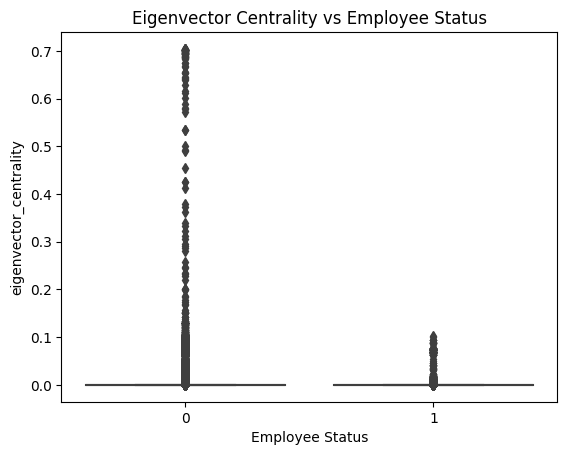

In [0]:
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows with NaN values in either column
df_centrality_cleaned = df_result_with_centrality_pd.dropna(subset=['eigenvector_centrality', 'Employee Status'])

# Convert 'Employee Status' to numeric values
df_centrality_cleaned['Employee Status'] = df_centrality_cleaned['Employee Status'].astype('category').cat.codes

# 7. Calculate correlation
pearson_corr, _ = pearsonr(df_centrality_cleaned['eigenvector_centrality'], df_centrality_cleaned['Employee Status'])
spearman_corr, _ = spearmanr(df_centrality_cleaned['eigenvector_centrality'], df_centrality_cleaned['Employee Status'])

print(f'Pearson correlation: {pearson_corr}')
print(f'Spearman correlation: {spearman_corr}')

# 8. Visualization
sns.boxplot(x='Employee Status', y='eigenvector_centrality', data=df_centrality_cleaned)
plt.title('Eigenvector Centrality vs Employee Status')
plt.show()

In [0]:
import pandas as pd
from scipy.stats import pointbiserialr

# Assume df_result_with_centrality_pd is your DataFrame
# Convert 'Employee Status' to a binary variable, where 'Active' is 0 and 'Terminated' is 1
df_result_with_centrality_pd['Employee Status Binary'] = df_result_with_centrality_pd['Employee Status'].map({'Active': 0, 'Terminated': 1})

# Calculate the Point-Biserial correlation coefficient
correlation, p_value = pointbiserialr(df_result_with_centrality_pd['Employee Status Binary'], df_result_with_centrality_pd['eigenvector_centrality'])

# Print the results
print(f'Point-Biserial Correlation: {correlation}')  # Display the correlation coefficient
print(f'P-value: {p_value}')  # Display the p-value for the correlation test


Point-Biserial Correlation: 0.0005107678268050902
P-value: 0.7981997095324549


### Change in Eigenvector Centrality

In [0]:
# Initialize the new column
df_result_with_centrality_pd['centrality_decrease'] = 0

# Sort by 'Person ID' and 'Reporting Date' to ensure correct order
df_result_with_centrality_pd.sort_values(by=['Person ID', 'Reporting Date'], inplace=True)

# Check for decrease in eigenvector centrality
for person_id, group in df_result_with_centrality_pd.groupby('Person ID'):
    for i in range(1, len(group)):
        current_centrality = group.iloc[i]['eigenvector_centrality']
        previous_centrality = group.iloc[i - 1]['eigenvector_centrality']
        
        if previous_centrality == 0 and current_centrality >= 0:
            continue  # No decrease if previous month has no data
        elif current_centrality < previous_centrality:
            df_result_with_centrality_pd.loc[group.index[i], 'centrality_decrease'] = 1

# Display the final DataFrame
print(df_result_with_centrality_pd)


       Reporting Date Person ID  ... Employee Status Binary centrality_decrease
79825      2018-10-31     10009  ...                      0                   0
236271     2018-11-30     10009  ...                      0                   1
133951     2018-12-31     10009  ...                      0                   0
178880     2019-01-31     10009  ...                      0                   0
202731     2019-02-28     10009  ...                      0                   0
...               ...       ...  ...                    ...                 ...
9208       2023-12-31     99911  ...                      0                   1
64654      2024-01-31     99911  ...                      0                   1
249168     2024-02-29     99911  ...                      0                   0
161275     2024-03-31     99911  ...                      0                   0
110727     2024-04-01     99911  ...                      0                   1

[250578 rows x 18 columns]


In [0]:
import pandas as pd

# Ensure 'Reporting Date' is a datetime column
df_result_with_centrality_pd['Reporting Date'] = pd.to_datetime(df_result_with_centrality_pd['Reporting Date'], errors='coerce')

# Now extract the year
df_result_with_centrality_pd['Year'] = df_result_with_centrality_pd['Reporting Date'].dt.year

# Group by 'Year' and 'Employee Status'
result_df = df_result_with_centrality_pd.groupby(['Year', 'Employee Status']).size().reset_index(name='Count')

# Display the result
display(result_df)


Year Employee Status Count 2018 Active 8977 2018 Terminated 123 2019 Active 40692 2019 Terminated 625 2020 Active 42728 2020 Terminated 761 2021 Active 43464 2021 Terminated 863 2022 Active 44571 2022 Terminated 1004 2023 Active 48645 2023 Terminated 752 2024 Active 17216 2024 Terminated 157

In [0]:
import pandas as pd
from scipy.stats import chi2_contingency

# Ensure the 'Reporting Date' column is in datetime format
df_result_with_centrality_pd['Reporting Date'] = pd.to_datetime(df_result_with_centrality_pd['Reporting Date'], errors='coerce')

# Create a contingency table
contingency_table = pd.crosstab(df_result_with_centrality_pd['centrality_decrease'], df_result_with_centrality_pd['Employee Status'])

# Perform the chi-squared test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Expected frequencies:\n{expected}")


Chi-squared statistic: 0.0798658333236563
P-value: 0.777479311638102
Expected frequencies:
[[133615.36296083   2324.63703917]
 [112677.63703917   1960.36296083]]


In [0]:
import pandas as pd
from scipy.stats import chi2_contingency

# Ensure the 'Reporting Date' column is in datetime format
df_result_with_centrality_pd['Reporting Date'] = pd.to_datetime(df_result_with_centrality_pd['Reporting Date'], errors='coerce')

# Filter the data to include only the year 2024
df_2024 = df_result_with_centrality_pd[df_result_with_centrality_pd['Reporting Date'].dt.year == 2024]

# Create a contingency table
contingency_table = pd.crosstab(df_2024['centrality_decrease'], df_2024['Employee Status'])

# Perform the chi-squared test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Expected frequencies:\n{expected}")


Chi-squared statistic: 19.04293351717814
P-value: 1.2781018320991334e-05
Expected frequencies:
[[9250.63949807   84.36050193]
 [7965.36050193   72.63949807]]


## Address Data Imbalance

In [0]:
import pandas as pd
# Create a new DataFrame to avoid modifying the original
df_result_with_centrality_final_1 = df_2024.copy()

# 1. Split the 'JH Job Family' column on the hyphen and trim the results
df_result_with_centrality_final_1['New JH Job Family'] = df_result_with_centrality_final_1['JH Job Family'].str.split('-').str[0].str.strip()

# 2. If the first part is 'Pre', keep the first and second parts; otherwise, keep only the first part
df_result_with_centrality_final_1['New JH Job Family'] = df_result_with_centrality_final_1.apply(
    lambda row: f"{row['New JH Job Family']}-{row['JH Job Family'].split('-')[1].strip()}" if row['JH Job Family'].startswith('Pre') else row['New JH Job Family'],
    axis=1
)

# 3. Initialize a new column 'Category' set to 'Uncategorized'
df_result_with_centrality_final_1['Category'] = 'Uncategorized'

# 4. Define the category mapping as a dictionary
category_mapping = {
    "Commercial and Contracts": ["Commercial", "Work Winning", "Commercial, Contracts & Procurement", 
                                 "Pre-Contracts", "Finance", "Property Development & Investment"],
    "Engineering and Technical": ["Engineering", "Technical & Design", "Design and Engineering", 
                                   "Project Controls", "Plant, Assets & Logistics"],
    "Project and Operations Management": ["Project Delivery", "Project Management", "Asset Management", 
                                          "Frontline Supervision", "Frontline Supervisor", "Construction Management",
                                          "Transport Operations", "Rail Network Operations"],
    "People and Communications": ["People", "Communications", "Communications/Community/Stakeholder Relations"],
    "Strategy and Leadership": ["Strategy", "Legacy"],
    "Legal and Compliance": ["Legal", "Quality", "HSC", "HSEQ"],
    "Administration and Support": ["Administration", "To Be Classified"],
    "IT and Technology": ["IT", "ICT"],
    "Trades and Labor": ["Trades and Labour"],
}

# 5. Update the 'Category' column based on the new job families
for category, families in category_mapping.items():
    df_result_with_centrality_final_1.loc[df_result_with_centrality_final_1['New JH Job Family'].isin(families), 'Category'] = category

# Display the resulting DataFrame
print(df_result_with_centrality_final_1.head(10))


       Reporting Date Person ID  ...  New JH Job Family           Category
94655      2024-01-31     10066  ...                 IT  IT and Technology
137011     2024-02-29     10066  ...                 IT  IT and Technology
35775      2024-03-31     10066  ...                 IT  IT and Technology
62042      2024-04-01     10066  ...                 IT  IT and Technology
194670     2024-01-31     10074  ...  Trades and Labour   Trades and Labor
148767     2024-02-29     10074  ...  Trades and Labour   Trades and Labor
155432     2024-03-31     10074  ...  Trades and Labour   Trades and Labor
174780     2024-04-01     10074  ...  Trades and Labour   Trades and Labor
249272     2024-01-31     10076  ...  Trades and Labour   Trades and Labor
173088     2024-02-29     10076  ...  Trades and Labour   Trades and Labor

[10 rows x 21 columns]


In [0]:
display(df_result_with_centrality_final_1['Category'].value_counts().reset_index().rename(columns={'index': 'JH Job Family', 'Category': 'Count'}))

JH Job Family Count Project and Operations Management 5936 Commercial and Contracts 2540 Legal and Compliance 2233 Engineering and Technical 1938 Trades and Labor 1855 People and Communications 1184 Administration and Support 1081 IT and Technology 606

In [0]:
df_result_with_centrality_final_1 = df_result_with_centrality_final_1.drop(['New JH Job Family', 'JH Job Family'], axis=1).rename(columns={'Category': 'JH Job Family'})

In [0]:
display(df_result_with_centrality_final_1.columns)

Index(['Reporting Date', 'Person ID', 'Employee Status', 'Division (Code)',
       'JH Position Title (externalCode)', 'External Title',
       'RCM State (externalName)', 'Age (Group)', 'BU',
       'Tenure (Group - Hire Date)', 'Manager/No Manager', 'Generation',
       'Job Level', 'Supervisor ID', 'eigenvector_centrality',
       'Employee Status Binary', 'centrality_decrease', 'Year',
       'JH Job Family'],
      dtype='object')

In [0]:
# df_result_with_centrality_final_1.to_csv('df_result_with_centrality_final_1.csv', index=False)

In [0]:
df_result_with_centrality_final = df_result_with_centrality_final_1.drop(['JH Position Title (externalCode)', 'External Title', 'Employee Status Binary', 'Generation'], axis=1)

In [0]:
df_result_with_centrality_final.isnull().sum()

Reporting Date                0
Person ID                     0
Employee Status               0
Division (Code)               0
RCM State (externalName)      0
Age (Group)                   0
BU                            0
Tenure (Group - Hire Date)    0
Manager/No Manager            0
Job Level                     0
Supervisor ID                 0
eigenvector_centrality        0
centrality_decrease           0
Year                          0
JH Job Family                 0
dtype: int64

In [0]:
display(df_result_with_centrality_final['Employee Status'].value_counts())

Active        17216
Terminated      157
Name: Employee Status, dtype: int64

In [0]:
# Define the values to be replaced
values_to_replace = ['Customer & Corp Affairs', 'Chief Operations Office', 'Commercial', 
                     'Executive Management', 'Finance & Group Services', 'HSE', 
                     'ICT', 'People', 'Strategy', 'WA Region']

# Replace the values in the 'BU' column
df_result_with_centrality_final['BU'] = df_result_with_centrality_final['BU'].replace(values_to_replace, 'Corporate')

# Display the resulting DataFrame
print(df_result_with_centrality_final.head(10))


       Reporting Date Person ID  ...  Year      JH Job Family
94655      2024-01-31     10066  ...  2024  IT and Technology
137011     2024-02-29     10066  ...  2024  IT and Technology
35775      2024-03-31     10066  ...  2024  IT and Technology
62042      2024-04-01     10066  ...  2024  IT and Technology
194670     2024-01-31     10074  ...  2024   Trades and Labor
148767     2024-02-29     10074  ...  2024   Trades and Labor
155432     2024-03-31     10074  ...  2024   Trades and Labor
174780     2024-04-01     10074  ...  2024   Trades and Labor
249272     2024-01-31     10076  ...  2024   Trades and Labor
173088     2024-02-29     10076  ...  2024   Trades and Labor

[10 rows x 15 columns]


In [0]:
# Group by 'BU' and count occurrences
grouped_counts = df_result_with_centrality_final.groupby('BU').size().reset_index(name='Count')

# Display the result
print(grouped_counts)

               BU  Count
0        Building   2366
1       Corporate   1589
2  Infrastructure   5175
3  Major Projects   4303
4            Rail   3576
5             TEK    364


In [0]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df_result_with_centrality_final['JH Job Family'], df_result_with_centrality_final['Employee Status'])

# Perform the chi-squared test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value: {p_value}")


Chi-squared statistic: 4.494806810131557
P-value: 0.721342531160654


In [0]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df_result_with_centrality_final['BU'], df_result_with_centrality_final['Employee Status'])

# Perform the chi-squared test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value: {p_value}")


Chi-squared statistic: 16.426032836815196
P-value: 0.005727359103951356


In [0]:
# import pandas as pd
# from scipy.stats import chi2_contingency

# # Get all columns except 'Employee Status'
# columns_to_test = df_result_with_centrality_final.columns.difference(['Employee Status', 'Person ID'])

# # Perform chi-squared test for each column
# results = {}
# for column in columns_to_test:
#     contingency_table = pd.crosstab(df_result_with_centrality_final[column], df_result_with_centrality_final['Employee Status'])
#     chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
#     results[column] = {'Chi-squared statistic': chi2_stat, 'P-value': p_value}

# # Convert results to DataFrame and reset index to add column names
# results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Column Name'})

# # Display the results
# display(results_df)

In [0]:
print(df_result_with_centrality_final['Reporting Date']=='2024-04-01')

94655     False
137011    False
35775     False
62042      True
194670    False
          ...  
201121     True
64654     False
249168    False
161275    False
110727     True
Name: Reporting Date, Length: 17373, dtype: bool


In [0]:
!pip install imblearn

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 6.7 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
# Display the column names of the Spark DataFrame 'df_result_with_centrality_final'
display(df_result_with_centrality_final.columns)

Index(['Reporting Date', 'Person ID', 'Employee Status', 'Division (Code)',
       'RCM State (externalName)', 'Age (Group)', 'BU',
       'Tenure (Group - Hire Date)', 'Manager/No Manager', 'Job Level',
       'Supervisor ID', 'eigenvector_centrality', 'centrality_decrease',
       'Year', 'JH Job Family'],
      dtype='object')

In [0]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
# from imblearn.over_sampling import SMOTE
# import joblib

# # Convert Spark DataFrame to Pandas DataFrame
# df = df_result_with_centrality_final

# # Columns with categorical data that need encoding
# categorical_columns = [col for col in df.columns if df[col].dtype == 'object' and col not in ['Employee Status', 'Reporting Date', 'Person ID', 'Supervisor ID', 'eigenvector_centrality']]

# # Create a dictionary to store mappings for each categorical column
# category_mapping = {}
# for column in categorical_columns:
#     # Get unique categorical values
#     unique_values = df[column].unique()
#     # Create a mapping dictionary
#     mapping = {value: idx for idx, value in enumerate(unique_values)}
#     # Store the mapping in category_mapping
#     category_mapping[column] = mapping
#     # Replace categorical values in the DataFrame with their mapped indices
#     df[column] = df[column].map(mapping)

# # Feature columns and target variable
# X = df.drop(['Employee Status', 'Reporting Date', 'Person ID', 'Supervisor ID', 'eigenvector_centrality'], axis=1)  # Feature columns
# y = df['Employee Status']  # Target variable

# # Apply SMOTE to handle class imbalance
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y)

# # Calculate the proportion of each class after SMOTE
# class_counts = pd.Series(y_resampled).value_counts()

# # Display the proportion of each class
# class_counts

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1234)

# # Create and train the Decision Tree model
# dt = DecisionTreeClassifier()
# dt.fit(X_train, y_train)

# # Make predictions
# y_pred = dt.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, pos_label='Terminated')  # Treat 'Terminated' as the positive class
# recall = recall_score(y_test, y_pred, pos_label='Terminated')
# f1 = f1_score(y_test, y_pred, pos_label='Terminated')
# roc_auc = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])  # Requires probability predictions
# conf_matrix = confusion_matrix(y_test, y_pred)

# print(f'Accuracy: {accuracy:.2f}')
# print(f'Precision: {precision:.2f}')
# print(f'Recall: {recall:.2f}')
# print(f'F1 Score: {f1:.2f}')
# print(f'ROC AUC: {roc_auc:.2f}')
# print(f'Confusion Matrix:\n{conf_matrix}')

# # Save the trained model
# joblib.dump(dt, 'decision_tree_model.pkl')
# joblib.dump(category_mapping, 'category_mapping.pkl')


In [0]:
# df_result_with_centrality_final.to_csv('df_result_with_centrality_final.csv', index=False)

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib

# Convert Spark DataFrame to Pandas DataFrame
df = df_result_with_centrality_final.copy()

# Columns with categorical data that need encoding
categorical_columns = [col for col in df.columns if df[col].dtype == 'object' and col not in ['Employee Status', 'Reporting Date', 'Person ID', 'Supervisor ID', 'eigenvector_centrality', 'JH Job Family']]

# Create a dictionary to store mappings for each categorical column
category_mapping = {}
for column in categorical_columns:
    # Get unique categorical values
    unique_values = df[column].unique()
    # Create a mapping dictionary
    mapping = {value: idx for idx, value in enumerate(unique_values)}
    # Store the mapping in category_mapping
    category_mapping[column] = mapping
    # Replace categorical values in the DataFrame with their mapped indices
    df[column] = df[column].map(mapping)

# Feature columns and target variable
X = df.drop(['Employee Status', 'Reporting Date', 'Person ID', 'Supervisor ID', 'eigenvector_centrality', 'JH Job Family', 'Year'], axis=1)  # Feature columns
y = df['Employee Status']  # Target variable

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Calculate the proportion of each class after SMOTE
class_counts = pd.Series(y_resampled).value_counts()

# Display the proportion of each class
print(class_counts)

# Create the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(dt, X_resampled, y_resampled, cv=10, scoring='accuracy')

# Print cross-validation results
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean accuracy from cross-validation: {cv_scores.mean():.2f} +/- {cv_scores.std():.2f}')

# Fit the model on the entire resampled dataset
dt.fit(X_resampled, y_resampled)

# Make predictions on the test set
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1234)
y_pred = dt.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Terminated')
recall = recall_score(y_test, y_pred, pos_label='Terminated')
f1 = f1_score(y_test, y_pred, pos_label='Terminated')
roc_auc = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])
conf_matrix = confusion_matrix(y_test, y_pred)

print(" ")
print(" ")
print(" ")
print(" ")
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Save the trained model and mappings
joblib.dump(dt, 'decision_tree_model.pkl')
joblib.dump(category_mapping, 'category_mapping.pkl')


Active        17216
Terminated    17216
Name: Employee Status, dtype: int64
Cross-validation scores: [0.90795587 0.92711963 0.93494046 0.87510892 0.90763869 0.89805402
 0.90996224 0.93290735 0.92651757 0.89689225]
Mean accuracy from cross-validation: 0.91 +/- 0.02
 
 
 
 
Accuracy: 0.93
Precision: 0.88
Recall: 0.99
F1 Score: 0.93
ROC AUC: 0.97
Confusion Matrix:
[[2990  455]
 [  30 3412]]


['category_mapping.pkl']

In [0]:
import joblib
import pandas as pd

# Load the trained model and category mappings
dt = joblib.load('decision_tree_model.pkl')
category_mapping = joblib.load('category_mapping.pkl')

# Filter the data for the specified reporting date
df_filtered = df[df['Reporting Date'] == '2024-04-01']

# # Ensure that the columns are correctly mapped according to the training process
# for column, mapping in category_mapping.items():
#     if column in df_filtered.columns:
#         # Print unique values before mapping
#         print(f"Unique values in {column} before mapping: {df_filtered[column].unique()}")
        
#         # Map the values
#         df_filtered[column] = df_filtered[column].map(mapping)
        
#         # Check for null values after mapping
#         null_count = df_filtered[column].isnull().sum()
#         print(f"Null values in {column} after mapping: {null_count}")
        
#         # Check unmapped values
#         unmapped_values = df_filtered[column][df_filtered[column].isnull()].unique()
#         print(f"Unmapped values in {column}: {unmapped_values}")


# Drop columns that are not used as features
X_filtered = df_filtered.drop(['Employee Status', 'Reporting Date', 'Person ID', 'Supervisor ID', 'eigenvector_centrality', 'JH Job Family', 'Year'], axis=1)
        
# Make predictions
predictions = dt.predict(X_filtered)

# Add the predictions back to the filtered DataFrame
df_filtered['Predictions'] = predictions

# Filter for employees predicted to be 'Terminated'
terminated_employees = df_filtered[df_filtered['Predictions'] == 'Terminated']

# Display the DataFrame with predictions
print(f"Number of terminated employees: {terminated_employees.shape[0]}")

# Get the 'Person ID' column of terminated employees
terminated_ids = terminated_employees[['Person ID']]

# # Find corresponding rows in df_spark
# terminated_ids.to_csv('terminated_employees.csv', index=False)

Number of terminated employees: 326


/home/spark-cb99c6f5-f7ec-4066-a02e-3f/.ipykernel/1552/command-429444083702347-2844835258:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Predictions'] = predictions


In [0]:
# 检查 terminated_employees.csv 中的 Person ID
print(terminated_employees['Person ID'].head())

# 检查 df_result_with_centrality_final 中的 Person ID
print(df_result_with_centrality_final['Person ID'].head())


235715     10678
138507    110252
74287     110571
206891    110996
225585    111264
Name: Person ID, dtype: object
94655     10066
137011    10066
35775     10066
62042     10066
194670    10074
Name: Person ID, dtype: object


## Data Error Case
The supervisor (59379) of the employee with person id 110243 who changed on 2023-12-11 had left the company as early as 2019-10-31

In [0]:
df_1 = df_spark.filter(F.col("Person ID") == "59379")
display(df_1)

Reporting Date Person ID Employee Status Employee Class Employment Type Company (externalCode) Company (Label) Division (Code) Division Subdivision (Code) Subdivision (Label) Department (Code) Department JH Job Family (externalCode) JH Job Family JH Position Title (externalCode) JH Position Title External Title Original Start Date Hire Date Last Day of Service Sub Termination Reason (externalCode) Sub Termination Reason (Label) Location Group (Name) RCM City RCM State (externalName) RCM Country (Picklist Label) Gender Age (Group) Proj / OH Placements BU Tenure (Group - Hire Date) Manager/No Manager Critical / Core Generation Diversity Question Job Level Department (PM) 2018-10-31 59379 Active Staff Full-Time Employee 100 John Holland Group RVIC Infrastructure VIC/SA & TAS RVOH VIC/SA & TAS Region OH RVRA VIC/SA/TAS/NZ Rail PRMG Project Management PDEL-RAIL-PRD Project Director Project Director 25/09/2017 1/02/2021 null R3 Resigned - Career Opportunity Victoria Melbourne Victoria Australia M 50 and more Overhead null Infrastructure Less than 1 yr Manager Critical Gen X 7 8 0 2019-07-31 59379 Active Staff Full-Time Employee 100 John Holland Group RAL Rail Group RALPR Rail Projects 7118R Metro Tunnel Rail Infrastructure Alliance - Rail PRMG Project Management PDEL-RAIL-PRD Project Director Project Director 25/09/2017 1/02/2021 null R3 Resigned - Career Opportunity Victoria Melbourne Victoria Australia M 50 and more Project null Rail Less than 1 yr Manager Critical Gen X 7 8 No Move 2019-08-31 59379 Active Staff Full-Time Employee 100 John Holland Group RAL Rail Group RALPR Rail Projects 7118R Metro Tunnel Rail Infrastructure Alliance - Rail PRMG Project Management PDEL-RAIL-PRD Project Director Project Director 25/09/2017 1/02/2021 null R3 Resigned - Career Opportunity Victoria Melbourne Victoria Australia M 50 and more Project null Rail Less than 1 yr Manager Critical Gen X 7 8 No Move 2019-10-31 59379 Terminated Staff Full-Time Employee 100 John Holland Group RAL Rail Group RALPR Rail Projects 7118R Metro Tunnel Rail Infrastructure Alliance - Rail PRMG Project Management PDEL-RAIL-PRD Project Director Project Director 25/09/2017 1/02/2021 null R3 Resigned - Career Opportunity Victoria Melbourne Victoria Australia M 50 and more Project null Rail Less than 1 yr Manager Critical Gen X 7 8 No Move 2019-11-30 59379 Terminated Staff Full-Time Employee 100 John Holland Group RAL Rail Group RALPR Rail Projects 7118R Metro Tunnel Rail Infrastructure Alliance - Rail PRMG Project Management PDEL-RAIL-PRD Project Director Project Director 25/09/2017 1/02/2021 null R3 Resigned - Career Opportunity Victoria Melbourne Victoria Australia M 50 and more Project null Rail Less than 1 yr Manager Critical Gen X 7 8 No Move 2019-12-31 59379 Terminated Staff Full-Time Employee 100 John Holland Group RAL Rail Group RALPR Rail Projects 7118R Metro Tunnel Rail Infrastructure Alliance - Rail PRMG Project Management PDEL-RAIL-PRD Project Director Project Director 25/09/2017 1/02/2021 null R3 Resigned - Career Opportunity Victoria Melbourne Victoria Australia M 50 and more Project null Rail Less than 1 yr Manager Critical Gen X 7 8 No Move 2018-11-30 59379 Active Staff Full-Time Employee 100 John Holland Group RAL Rail Group RALPR Rail Projects 7118A Metro Tunnel Rail Infrastructure Alliance PRMG Project Management PDEL-RAIL-PRD Project Director Project Director 25/09/2017 1/02/2021 null R3 Resigned - Career Opportunity Victoria Melbourne Victoria Australia M 50 and more Project Overhead to Project Rail Less than 1 yr Manager Critical Gen X 7 8 VIC/SA/TAS/NZ Rail 2018-12-31 59379 Active Staff Full-Time Employee 100 John Holland Group RAL Rail Group RALPR Rail Projects 7118R Metro Tunnel Rail Infrastructure Alliance - Rail PRMG Project Management PDEL-RAIL-PRD Project Director Project Director 25/09/2017 1/02/2021 null R3 Resigned - Career Opportunity Victoria Melbourne Victoria Australia M 50 and more Project Project to Project Rail Less than 1 yr Manager 

In [0]:
from pyspark.sql.functions import col

df_2 = df_manager_spark.filter(
    (col("Person ID") == "110243")
).select("Person ID", "Event Date", "Supervisor ID") 

display(df_2)


Person ID Event Date Supervisor ID 110243 2018-11-14 81701 110243 2018-11-28 90825 110243 2019-03-05 56332 110243 2020-01-01 90825 110243 2021-12-17 56332 110243 2022-12-23 30732 110243 2023-01-12 111186 110243 2023-12-11 59379

## ABM

In [0]:
!pip install mesa
!pip install networkx

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.2/751.2 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import networkx as nx
import matplotlib.pyplot as plt

In [0]:
# class EmployeeAgent(Agent):
#     def __init__(self, unique_id, model, data):
#         """
#         Initialize the EmployeeAgent.
#         :param unique_id: The unique identifier for the employee.
#         :param model: The model instance.
#         :param data: A dictionary of employee data.
#         """
#         super().__init__(data['Person ID'], model)
#         self.bu = data['BU']
#         self.is_active = True
#         self.supervisor_id = data['Supervisor ID']
#         self.data = data  # Store the employee's data
        
#         # Load the trained Decision Tree model and category mappings
#         self.dt_model = joblib.load('decision_tree_model.pkl')
#         self.category_mapping = joblib.load('category_mapping.pkl')

#     ################################
#     ##############################
#     #############################
#     # Need to improve
#     # def encode_data(self, data):
#     #     """
#     #     Encode categorical data based on the saved mappings.
#     #     :param data: A dictionary of employee data to encode.
#     #     :return: Encoded DataFrame.
#     #     """
#     #     encoded_data = {}
#     #     for column, value in data.items():
#     #         if column in self.category_mapping:
#     #             encoded_data[column] = self.category_mapping[column].get(value, -1)  # -1 for unknown values
#     #         else:
#     #             encoded_data[column] = value
#     #     return pd.DataFrame([encoded_data])
    
#     def step(self):
#         """
#         Define the agent's behavior at each step of the simulation.
#         """     
#         # Prepare input data for the model
#         input_data = pd.DataFrame([{
#             'Division (Code)': self.data['Division (Code)'],
#             'RCM State (externalName)': self.data['RCM State (externalName)'],
#             'Age (Group)': self.data['Age (Group)'],
#             'BU': self.bu,
#             'Tenure (Group - Hire Date)': self.data['Tenure (Group - Hire Date)'],
#             'Manager/No Manager': self.data['Manager/No Manager'],
#             'Job Level': self.data['Job Level'],
#             'centrality_decrease': self.data['centrality_decrease']
#         }])

#         # Debugging output
#         print(f'Input data for prediction: {input_data}')

#         # Make prediction
#         predicted_label = self.dt_model.predict(input_data)[0]  # Predict class label directly

#         # Debugging output
#         print(f'Predicted label: {predicted_label}')

#         if predicted_label == 'Terminated':  # Check if the prediction is 'Terminated'
#             self.is_active = False
#             self.model.schedule.remove(self)
#             self.model.graph.remove_node(self.unique_id)
#             print(f'Employee {self.unique_id} terminated and removed from the model')

# class CompanyModel(Model):
#     def __init__(self, employee_data):
#         """
#         Initialize the CompanyModel.
#         :param employee_data: DataFrame containing employee data.
#         """
#         super().__init__()
#         self.schedule = RandomActivation(self)
#         self.running = True 

#         # Initialize NetworkX graph for employee-manager relationships
#         self.graph = nx.DiGraph()

#         # Extract unique BU values from the data
#         self.bu_values = employee_data['BU'].unique().tolist()
#         self.employee_data = employee_data

#         # Add initial employees to the model
#         for i, row in employee_data.iterrows():
#             self.add_employee(row)

#         # Initialize DataCollector to track BU changes and steps
#         self.datacollector = DataCollector(
#             agent_reporters={"BU": "bu"},
#             model_reporters={"BU_counts": self.count_bu}
#         )
#         self.step_counter = 0  # Initialize step counter
    
#     def add_employee(self, data):
#         """
#         Add an employee to the model.
#         :param data: A dictionary of employee data.
#         """
#         employee = EmployeeAgent(data['Person ID'], self, data)
#         self.schedule.add(employee)

#         # Add employee to NetworkX graph
#         self.graph.add_node(employee.unique_id, bu=employee.bu)
#         supervisor_id = data.get('Supervisor ID')
#         if supervisor_id and supervisor_id in self.graph.nodes:
#             self.graph.add_edge(supervisor_id, employee.unique_id)

#     def step(self):
#         """
#         Advance the model by one step.
#         """
#         self.schedule.step()
#         self.datacollector.collect(self)

#         # Remove inactive employees and update the NetworkX graph
#         for agent in list(self.schedule.agents):
#             if not agent.is_active:
#                 self.schedule.remove(agent)
#                 self.graph.remove_node(agent.unique_id)
    
#     # def count_bu(self):
#     #     bu_count = {bu: 0 for bu in self.bu_values}
#     #     for agent in self.schedule.agents:
#     #         if agent.is_active:
#     #             bu_count[agent.bu] += 1
#     #     return bu_count



---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1095413598262905>, line 1
----> 1 class EmployeeAgent(Agent):
      2     def __init__(self, unique_id, model, data):
      3         """
      4         Initialize the EmployeeAgent.
      5         :param unique_id: The unique identifier for the employee.
      6         :param model: The model instance.
      7         :param data: A dictionary of employee data.
      8         """

NameError: name 'Agent' is not defined

In [0]:
# def visualize_network(graph, step):
#     """
#     Visualize the NetworkX graph.
#     :param graph: A NetworkX DiGraph instance representing the employee-manager relationships.
#     :param step: The current step of the simulation.
#     """
#     plt.figure(figsize=(10, 7))
#     pos = nx.spring_layout(graph)  # Compute the layout for visualizing
#     nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold', edge_color='gray', arrows=True)
#     plt.title(f'Network - Step {step}')
#     plt.show()
#     # time.sleep(1)  # Add delay to visualize changes step-by-step

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1095413598262905>, line 1
----> 1 class EmployeeAgent(Agent):
      2     def __init__(self, unique_id, model, data):
      3         """
      4         Initialize the EmployeeAgent.
      5         :param unique_id: The unique identifier for the employee.
      6         :param model: The model instance.
      7         :param data: A dictionary of employee data.
      8         """

NameError: name 'Agent' is not defined

In [0]:
# # # Filter the DataFrame for the specific reporting date
# # example_data_spark = df_baseline_final.filter(F.col('Reporting Date') == '2024-04-01').limit(100)
# # example_data = example_data_spark.toPandas()
# # display(example_data_spark)

# # Convert 'Reporting Date' to datetime if it is not already
# df_result_with_centrality_final['Reporting Date'] = pd.to_datetime(df_result_with_centrality_final['Reporting Date'], errors='coerce')

# # Now filter by the specific date
# example_data = df_result_with_centrality_final[df_result_with_centrality_final['Reporting Date'] == '2024-04-01']
# # Get only the first 100 rows of the filtered data
# example_data_sample = example_data.head(100)

# # # Print the count of the sampled data
# # print(example_data_sample.count())
# # display(example_data_sample)
# # Create and run the model instance
# model = CompanyModel(employee_data=example_data_sample)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1095413598262905>, line 1
----> 1 class EmployeeAgent(Agent):
      2     def __init__(self, unique_id, model, data):
      3         """
      4         Initialize the EmployeeAgent.
      5         :param unique_id: The unique identifier for the employee.
      6         :param model: The model instance.
      7         :param data: A dictionary of employee data.
      8         """

NameError: name 'Agent' is not defined

In [0]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import joblib

class EmployeeAgent(Agent):
    def __init__(self, unique_id, model, data):
        """
        Initialize the EmployeeAgent.
        :param unique_id: The unique identifier for the employee.
        :param model: The model instance.
        :param data: A dictionary of employee data.
        """
        super().__init__(data['Person ID'], model)
        self.bu = data['BU']
        self.is_active = True
        self.supervisor_id = data['Supervisor ID']
        self.data = data
        self.status = 'Active'  # Initialize the status of the employee

        # Load the trained Decision Tree model and category mappings
        self.dt_model = joblib.load('decision_tree_model.pkl')
        self.category_mapping = joblib.load('category_mapping.pkl')

    def step(self):
        """
        Define the agent's behavior at each step of the simulation.
        """
        # Prepare input data for the model
        input_data = pd.DataFrame([{
            'Division (Code)': self.data['Division (Code)'],
            'RCM State (externalName)': self.data['RCM State (externalName)'],
            'Age (Group)': self.data['Age (Group)'],
            'BU': self.bu,
            'Tenure (Group - Hire Date)': self.data['Tenure (Group - Hire Date)'],
            'Manager/No Manager': self.data['Manager/No Manager'],
            'Job Level': self.data['Job Level'],
            'centrality_decrease': self.data['centrality_decrease']
        }])

        # Apply the category mapping to the input data
        for column in self.category_mapping:
            if column in input_data.columns:
                input_data[column] = input_data[column].map(self.category_mapping[column])

        # Predict the employee's status using the decision tree model
        predicted_label = self.dt_model.predict(input_data)[0]

        # If the predicted label is 'Terminated', mark the employee as inactive and update the status
        if predicted_label == 'Terminated':
            self.is_active = False  # Mark as inactive
            self.model.graph.nodes[self.unique_id]['status'] = 'Terminated'  # Update status in graph
            print(f'Employee {self.unique_id} marked as terminated')

class CompanyModel(Model):
    def __init__(self, employee_data):
        """
        Initialize the CompanyModel.
        :param employee_data: DataFrame containing employee data.
        """
        super().__init__()
        self.schedule = RandomActivation(self)
        self.running = True

        # Initialize NetworkX graph for employee-manager relationships
        self.graph = nx.DiGraph()

        # Add initial employees to the model
        for i, row in employee_data.iterrows():
            self.add_employee(row)

    def add_employee(self, data):
        """
        Add an employee to the model and the NetworkX graph.
        """
        employee = EmployeeAgent(data['Person ID'], self, data)
        self.schedule.add(employee)

        # Add employee node to the graph with the status and BU information
        self.graph.add_node(employee.unique_id, status=employee.status, bu=employee.bu)

        supervisor_id = data.get('Supervisor ID')
        
        # Check if supervisor_id is valid and not 'NO_MANAGER'
        if supervisor_id and supervisor_id != 'NO_MANAGER' and supervisor_id in self.graph.nodes:
            self.graph.add_edge(supervisor_id, employee.unique_id)

    def step(self):
        """
        Advance the model by one step and collect data.
        """
        self.schedule.step()

    def extract_terminated_nodes(self):
        """
        Extract nodes that are marked as 'Terminated' in the graph.
        """
        # Get all nodes with the status 'Terminated'
        terminated_nodes = [n for n, data in self.graph.nodes(data=True) if data.get('status') == 'Terminated']

        # # Debugging output
        # print("Terminated Nodes count:", len(terminated_nodes))

        return terminated_nodes

def extract_subgraph_with_terminated(graph, terminated_nodes):
    """
    Extract subgraphs containing terminated employees and their related nodes.
    :param graph: The original employee-manager graph (NetworkX DiGraph).
    :param terminated_nodes: List of employee nodes marked as 'Terminated'.
    :return: List of subgraphs containing terminated employees and their connections.
    """
    subgraphs = []
    seen_nodes = set()  # To track nodes that are already included in a subgraph

    # Start creating a new subgraph if there are terminated nodes to process
    for node in terminated_nodes:
        if node in seen_nodes:
            continue  # Skip already seen nodes

        # Create a new set for the current subgraph
        current_subgraph_nodes = set()
        
        # Add the current terminated employee
        current_subgraph_nodes.add(node)

        # Use a queue for BFS to gather connected nodes
        queue = [node]
        
        while queue:
            current_node = queue.pop(0)

            # Get all subordinates and supervisors
            connected_nodes = list(nx.descendants(graph, current_node))  # Get all subordinates
            connected_nodes += list(nx.ancestors(graph, current_node))  # Get all supervisors

            for connected in connected_nodes:
                if connected not in seen_nodes and connected not in current_subgraph_nodes:
                    current_subgraph_nodes.add(connected)
                    queue.append(connected)

        # Include active employees connected to the current subgraph nodes
        for current in list(current_subgraph_nodes):
            if graph.nodes[current]['status'] == 'Active':
                current_subgraph_nodes.add(current)

        # Add the current subgraph nodes to seen_nodes
        seen_nodes.update(current_subgraph_nodes)

        # If the current subgraph has less than 100 nodes, try adding the next terminated employee
        while len(current_subgraph_nodes) < 100 and terminated_nodes:
            next_terminated = terminated_nodes.pop(0)  # Get the next terminated employee
            if next_terminated in seen_nodes:
                continue  # Skip if already processed

            # Add the next terminated employee to the subgraph
            current_subgraph_nodes.add(next_terminated)

            # Use BFS again to gather connected nodes for the new terminated employee
            queue = [next_terminated]
            while queue:
                current_node = queue.pop(0)
                connected_nodes = list(nx.descendants(graph, current_node))  # Get all subordinates
                connected_nodes += list(nx.ancestors(graph, current_node))  # Get all supervisors

                for connected in connected_nodes:
                    if connected not in seen_nodes and connected not in current_subgraph_nodes:
                        current_subgraph_nodes.add(connected)
                        queue.append(connected)

            # # Include active employees connected to the new subgraph nodes
            # for current in list(current_subgraph_nodes):
            #     if graph.nodes[current]['status'] == 'Active':
            #         current_subgraph_nodes.add(current)

            # Update seen nodes
            seen_nodes.update(current_subgraph_nodes)

        # If the subgraph has at least 100 nodes, create and store it
        if len(current_subgraph_nodes) >= 100:
            subgraph = graph.subgraph(current_subgraph_nodes)
            subgraphs.append(subgraph)

    return subgraphs

# Visualize multiple subgraphs
def visualize_subgraphs(subgraphs):
    """
    Visualize multiple subgraphs using Matplotlib.
    :param subgraphs: List of NetworkX graphs to visualize.
    """
    for i, graph in enumerate(subgraphs):
        plt.figure(figsize=(10, 10))
        pos = nx.spring_layout(graph)  # Use force-directed layout
        
        # Determine node colors based on status
        node_colors = ['gray' if data['status'] == 'Terminated' else 'lightblue' for _, data in graph.nodes(data=True)]
        
        # Determine edge colors based on status
        edge_colors = []
        for u, v in graph.edges():
            if graph.nodes[u].get('status') == 'Terminated' or graph.nodes[v].get('status') == 'Terminated':
                edge_colors.append('red') 
            else:
                edge_colors.append('black')  

        nx.draw(graph, pos, with_labels=True, node_color=node_colors, font_size=8, node_size=500)
        nx.draw_networkx_edges(graph, pos, edge_color=edge_colors)
        plt.title(f"Subgraph {i + 1} of Terminated Employees and Related Nodes")
        plt.show()

def run_simulation(model):
    """
    Run the simulation and visualize the subgraph of terminated employees.
    :param model: Instance of the CompanyModel.
    """
    for _ in range(10):  # Run the model for 10 steps
        model.step()

    # Get all terminated employees
    terminated_nodes = model.extract_terminated_nodes()

    # Extract the subgraphs of terminated employees and their connections
    terminated_subgraphs = extract_subgraph_with_terminated(model.graph, terminated_nodes)

    # Visualize the subgraphs
    visualize_subgraphs(terminated_subgraphs)


In [0]:
# def extract_subgraph_with_terminated(graph, terminated_nodes):
#     """
#     Extract subgraphs containing terminated employees and their related nodes.
#     :param graph: The original employee-manager graph (NetworkX DiGraph).
#     :param terminated_nodes: List of employee nodes marked as 'Terminated'.
#     :return: List of subgraphs containing terminated employees and their connections.
#     """
#     subgraphs = []
#     seen_nodes = set()  # To track nodes that are already included in a subgraph

#     # Start creating a new subgraph if there are terminated nodes to process
#     for node in terminated_nodes:
#         if node in seen_nodes:
#             continue  # Skip already seen nodes

#         # Create a new set for the current subgraph
#         current_subgraph_nodes = set()
        
#         # Add the current terminated employee
#         current_subgraph_nodes.add(node)

#         # Use a queue for BFS to gather connected nodes
#         queue = [node]
        
#         while queue:
#             current_node = queue.pop(0)

#             # Get all subordinates and supervisors
#             connected_nodes = list(nx.descendants(graph, current_node))  # Get all subordinates
#             connected_nodes += list(nx.ancestors(graph, current_node))  # Get all supervisors

#             for connected in connected_nodes:
#                 if connected not in seen_nodes and connected not in current_subgraph_nodes:
#                     current_subgraph_nodes.add(connected)
#                     queue.append(connected)

#         # Include active employees connected to the current subgraph nodes
#         for current in list(current_subgraph_nodes):
#             if graph.nodes[current]['status'] == 'Active':
#                 current_subgraph_nodes.add(current)

#         # Add the current subgraph nodes to seen_nodes
#         seen_nodes.update(current_subgraph_nodes)

#         # If the current subgraph has less than 100 nodes, try adding the next terminated employee
#         while len(current_subgraph_nodes) < 100 and terminated_nodes:
#             next_terminated = terminated_nodes.pop(0)  # Get the next terminated employee
#             if next_terminated in seen_nodes:
#                 continue  # Skip if already processed

#             # Add the next terminated employee to the subgraph
#             current_subgraph_nodes.add(next_terminated)

#             # Use BFS again to gather connected nodes for the new terminated employee
#             queue = [next_terminated]
#             while queue:
#                 current_node = queue.pop(0)
#                 connected_nodes = list(nx.descendants(graph, current_node))  # Get all subordinates
#                 connected_nodes += list(nx.ancestors(graph, current_node))  # Get all supervisors

#                 for connected in connected_nodes:
#                     if connected not in seen_nodes and connected not in current_subgraph_nodes:
#                         current_subgraph_nodes.add(connected)
#                         queue.append(connected)

#             # Include active employees connected to the new subgraph nodes
#             for current in list(current_subgraph_nodes):
#                 if graph.nodes[current]['status'] == 'Active':
#                     current_subgraph_nodes.add(current)

#             # Update seen nodes
#             seen_nodes.update(current_subgraph_nodes)

#         # If the subgraph has at least 100 nodes, create and store it
#         if len(current_subgraph_nodes) >= 100:
#             subgraph = graph.subgraph(current_subgraph_nodes)
#             subgraphs.append(subgraph)

#     return subgraphs

# # Visualize multiple subgraphs
# def visualize_subgraphs(subgraphs):
#     """
#     Visualize multiple subgraphs using Matplotlib.
#     :param subgraphs: List of NetworkX graphs to visualize.
#     """
#     for i, graph in enumerate(subgraphs):
#         plt.figure(figsize=(10, 10))
#         pos = nx.spring_layout(graph)  # Use force-directed layout
        
#         # Determine node colors based on status
#         node_colors = ['gray' if data['status'] == 'Terminated' else 'lightblue' for _, data in graph.nodes(data=True)]
        
#         # Draw edges as dashed for gray nodes
#         edge_styles = [('dashed' if data['status'] == 'Terminated' else 'solid') for _, _, data in graph.edges(data=True)]
        
#         nx.draw(graph, pos, with_labels=True, node_color=node_colors, font_size=8, node_size=500, edge_color=edge_styles)
#         plt.title(f"Subgraph {i + 1} of Terminated Employees and Related Nodes")

#         # Print terminated nodes for this subgraph
#         terminated_nodes = [node for node in graph.nodes() if graph.nodes[node]['status'] == 'Terminated']
#         print(f'Terminated nodes in Subgraph {i + 1}: {terminated_nodes}')

#         plt.show()

# def run_simulation(model):
#     """
#     Run the simulation and visualize the subgraph of terminated employees.
#     :param model: Instance of the CompanyModel.
#     """
#     for _ in range(10):  # Run the model for 10 steps
#         model.step()

#     # Get all terminated employees
#     terminated_nodes = model.extract_terminated_nodes()

#     # Extract the subgraphs of terminated employees and their connections
#     terminated_subgraphs = extract_subgraph_with_terminated(model.graph, terminated_nodes)

#     # Visualize the subgraphs
#     visualize_subgraphs(terminated_subgraphs)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1095413598262905>, line 1
----> 1 class EmployeeAgent(Agent):
      2     def __init__(self, unique_id, model, data):
      3         """
      4         Initialize the EmployeeAgent.
      5         :param unique_id: The unique identifier for the employee.
      6         :param model: The model instance.
      7         :param data: A dictionary of employee data.
      8         """

NameError: name 'Agent' is not defined

In [0]:
# Convert 'Reporting Date' to datetime if it is not already
df_result_with_centrality_final['Reporting Date'] = pd.to_datetime(df_result_with_centrality_final['Reporting Date'], errors='coerce')

# Now filter by the specific date
example_data = df_result_with_centrality_final[df_result_with_centrality_final['Reporting Date'] == '2024-04-01']
# Get only the first 100 rows of the filtered data
example_data_sample = example_data.head(1000).copy()

# # Print the count of the sampled data
# print(example_data_sample.count())
# display(example_data_sample)
# Create and run the model instance
model = CompanyModel(employee_data=example_data_sample)

# Run the simulation and visualize the terminated employees' subgraph
run_simulation(model)

### testing

In [0]:
import networkx as nx
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
import joblib

class EmployeeAgent(Agent):
    def __init__(self, unique_id, model, data):
        """
        Initialize the Employee Agent
        :param unique_id: Unique ID of the employee
        :param model: Model instance
        :param data: Specific information of the employee
        """
        super().__init__(data['Person ID'], model)  # Call the parent constructor with the unique ID
        self.data = data  # Store employee data
        self.bu = data['BU']  # Store the business unit
        self.supervisor_id = data['Supervisor ID']  # Store the supervisor ID
        self.status = 'Active'  # Initialize status as active
        self.previous_centrality = data['eigenvector_centrality']  # Store previous centrality

        # Load decision tree model and category mapping
        self.dt_model = joblib.load('decision_tree_model.pkl')
        self.category_mapping = joblib.load('category_mapping.pkl')

    def step(self):
        """
        Employee behavior logic for each step
        """
        if self.status == 'Terminated':
            return  # Skip if the employee status is terminated

        # Prepare input data for the model
        input_data = pd.DataFrame([{
            'Division (Code)': self.data['Division (Code)'],
            'RCM State (externalName)': self.data['RCM State (externalName)'],
            'Age (Group)': self.data['Age (Group)'],
            'BU': self.bu,
            'Tenure (Group - Hire Date)': self.data['Tenure (Group - Hire Date)'],
            'Manager/No Manager': self.data['Manager/No Manager'],
            'Job Level': self.data['Job Level'],
            'centrality_decrease': self.data['centrality_decrease']
        }])

        # Apply category mapping
        for column in self.category_mapping:
            if column in input_data.columns:
                input_data[column] = input_data[column].map(self.category_mapping[column])

        # Use the decision tree model to predict employee status
        predicted_label = self.dt_model.predict(input_data)[0]

        # If the predicted result is termination, mark as terminated and update the graph
        if predicted_label == 'Terminated':
            self.status = 'Terminated'  # Update status
            self.model.graph.nodes[self.unique_id]['status'] = self.status  # Update status in the graph
            print(f'Employee {self.unique_id} marked as terminated')


class CompanyModel(Model):
    def __init__(self, employee_data):
        """
        Initialize the Company Model
        :param employee_data: Data containing employee information
        """
        super().__init__()  # Call the parent constructor
        self.schedule = RandomActivation(self)  # Initialize the schedule
        self.running = True  # Set the model to running

        # Initialize a NetworkX directed graph
        self.graph = nx.DiGraph()

        # Add employees to the model
        for i, row in employee_data.iterrows():
            self.add_employee(row)

    def add_employee(self, data):
        """
        Add an employee to the model
        """
        employee = EmployeeAgent(data['Person ID'], self, data)  # Create an EmployeeAgent instance
        self.schedule.add(employee)  # Add the employee to the schedule

        # Add employee node to the graph and initialize status and BU information
        self.graph.add_node(employee.unique_id, status=employee.status, bu=employee.bu)

        supervisor_id = data.get('Supervisor ID')  # Get the supervisor ID
        
        # If the supervisor ID is valid and not "NO_MANAGER", add an edge
        if supervisor_id and supervisor_id != 'NO_MANAGER' and supervisor_id in self.graph.nodes:
            self.graph.add_edge(supervisor_id, employee.unique_id)

    def remove_employees(self, person_ids):
        """
        Remove employees from the graph based on the input person ID list
        :param person_ids: List of person IDs to remove
        """
        for person_id in person_ids:
            if person_id in self.graph.nodes:
                print(f'Removing employee {person_id}')
                # Remove the employee's node from the graph
                self.graph.remove_node(person_id)

                # Iterate through the nodes in the graph to check if subordinates need to update their Supervisor ID
                for node, data in self.graph.nodes(data=True):
                    if self.graph.nodes[node].get('Supervisor ID') == person_id:
                        self.graph.nodes[node]['Supervisor ID'] = 'NO_MANAGER'
                        print(f'Employee {node} now reports to NO_MANAGER')

        # Recalculate the graph's centrality
        self.recalculate_centrality()

    def recalculate_centrality(self):
        """
        Recalculate eigenvector centrality and decrease centrality
        """
        # Calculate the current eigenvector centrality
        current_centrality = nx.eigenvector_centrality(self.graph, max_iter=1000)
        
        # Update the centrality information for each node
        for node in self.graph.nodes:
            # Get the current centrality value
            self.graph.nodes[node]['current_centrality'] = current_centrality.get(node, 0)
            previous_centrality = self.graph.nodes[node].get('previous_centrality', 0)

            # Check for centrality decrease
            if previous_centrality != 0 and self.graph.nodes[node]['current_centrality'] < previous_centrality:
                self.graph.nodes[node]['centrality_decrease'] = 1
            else:
                self.graph.nodes[node]['centrality_decrease'] = 0
            
            # Update previous_centrality to the current value
            self.graph.nodes[node]['previous_centrality'] = self.graph.nodes[node]['current_centrality']


    def step(self):
        """
        Each step of the model
        """
        # Input the list of person IDs to delete
        person_ids = input("Enter person IDs to terminate (comma-separated): ").split(',')
        person_ids = [int(pid.strip()) for pid in person_ids]  # Convert to integers

        # Remove the corresponding employees and update the graph
        self.remove_employees(person_ids)

        # Call the decision tree model and continue executing employee behavior
        self.schedule.step()

        # Print the graph status (optional)
        print("Current Graph Status:")
        print(self.graph.nodes(data=True))


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1095413598262905>, line 1
----> 1 class EmployeeAgent(Agent):
      2     def __init__(self, unique_id, model, data):
      3         """
      4         Initialize the EmployeeAgent.
      5         :param unique_id: The unique identifier for the employee.
      6         :param model: The model instance.
      7         :param data: A dictionary of employee data.
      8         """

NameError: name 'Agent' is not defined

In [0]:
# Convert 'Reporting Date' to datetime if it is not already
df_result_with_centrality_final['Reporting Date'] = pd.to_datetime(df_result_with_centrality_final['Reporting Date'], errors='coerce')

# Now filter by the specific date
example_data = df_result_with_centrality_final[df_result_with_centrality_final['Reporting Date'] == '2024-04-01']
# Get only the first 100 rows of the filtered data
example_data_sample = example_data.head(100).copy()

# # Initialize the model
# model = CompanyModel(example_data_sample)

# # First step: input the IDs of employees to be terminated
# person_ids = input("Enter person IDs to terminate in the first step (comma-separated): ").split(',')
# person_ids = [int(pid.strip()) for pid in person_ids]

# # Remove corresponding employees and update the graph
# model.remove_employees(person_ids)

# # Run the subsequent steps of the model
# for step in range(2):  # Continue for 2 more steps
#     print(f"Step {step + 2}")
    
#     # Call the decision tree model to continue executing employee behaviors
#     model.schedule.step()

#     # # Print the current graph status
#     # print("Current Graph Status:")
#     # print(model.graph.nodes(data=True))

#     # # Optional: Check the status of each employee
#     # for agent in model.schedule.agents:
#     #     print(f"Employee ID: {agent.unique_id}, Status: {agent.status}, Previous Centrality: {agent.previous_centrality}")

# print("Model simulation finished.")


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1095413598262905>, line 1
----> 1 class EmployeeAgent(Agent):
      2     def __init__(self, unique_id, model, data):
      3         """
      4         Initialize the EmployeeAgent.
      5         :param unique_id: The unique identifier for the employee.
      6         :param model: The model instance.
      7         :param data: A dictionary of employee data.
      8         """

NameError: name 'Agent' is not defined

In [0]:
import networkx as nx
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
import joblib
import matplotlib.pyplot as plt

class EmployeeAgent(Agent):
    def __init__(self, unique_id, model, data):
        """
        Initialize the employee agent.
        :param unique_id: The unique ID of the employee.
        :param model: Instance of the model.
        :param data: Specific information about the employee.
        """
        super().__init__(data['Person ID'], model)
        self.data = data
        self.bu = data['BU']  # Business Unit
        self.supervisor_id = data['Supervisor ID']
        self.status = 'Active'  # Initial status of the employee
        self.previous_centrality = data['eigenvector_centrality']  # Previous centrality value

        # Load the pre-trained decision tree model and category mapping
        self.dt_model = joblib.load('decision_tree_model.pkl')
        self.category_mapping = joblib.load('category_mapping.pkl')

    def step(self):
        """
        Employee behavior logic for each step.
        """
        if self.status == 'Terminated':
            return  # Skip if the employee's status is 'Terminated'

        # Prepare input data for the model
        input_data = pd.DataFrame([{
            'Division (Code)': self.data['Division (Code)'],
            'RCM State (externalName)': self.data['RCM State (externalName)'],
            'Age (Group)': self.data['Age (Group)'],
            'BU': self.bu,
            'Tenure (Group - Hire Date)': self.data['Tenure (Group - Hire Date)'],
            'Manager/No Manager': self.data['Manager/No Manager'],
            'Job Level': self.data['Job Level'],
            'centrality_decrease': self.data['centrality_decrease']
        }])

        # Apply category mapping to input data
        for column in self.category_mapping:
            if column in input_data.columns:
                input_data[column] = input_data[column].map(self.category_mapping[column])

        # Use the decision tree model to predict employee status
        predicted_label = self.dt_model.predict(input_data)[0]

        # If the predicted result is 'Terminated', update the status and the graph
        if predicted_label == 'Terminated':
            self.status = 'Terminated'  # Update status
            self.model.graph.nodes[self.unique_id]['status'] = self.status  # Update status in the graph
            print(f'Employee {self.unique_id} marked as terminated')

class CompanyModel(Model):
    def __init__(self, employee_data):
        """
        Initialize the company model.
        :param employee_data: Data containing employee information.
        """
        super().__init__()
        self.schedule = RandomActivation(self)  # Initialize the schedule for agents
        self.running = True

        # Initialize a directed graph using NetworkX
        self.graph = nx.DiGraph()

        # Add employees to the model
        for i, row in employee_data.iterrows():
            self.add_employee(row)

    def add_employee(self, data):
        """
        Add an employee to the model.
        :param data: Employee data.
        """
        employee = EmployeeAgent(data['Person ID'], self, data)
        self.schedule.add(employee)  # Add employee to the schedule

        # Add employee node to the graph and initialize status and BU information
        self.graph.add_node(employee.unique_id, status=employee.status, bu=employee.bu)

        supervisor_id = data.get('Supervisor ID')

        # If the Supervisor ID is valid and not 'NO_MANAGER', add an edge
        if supervisor_id and supervisor_id != 'NO_MANAGER' and supervisor_id in self.graph.nodes:
            self.graph.add_edge(supervisor_id, employee.unique_id)

    def remove_employees(self, person_ids):
        """
        Remove employees from the graph based on the input person ID list and update the graph.
        :param person_ids: List of employee IDs to remove.
        """
        for person_id in person_ids:
            print(f'Marking employee {person_id} as terminated')
            # Update employee status to 'Terminated'
            self.graph.nodes[person_id]['status'] = 'Terminated'

            if person_id in self.graph.nodes:
                print(f'Removing employee {person_id}')
                # Remove the employee node from the graph
                self.graph.remove_node(person_id)

                # Check each node in the graph to update Supervisor ID for subordinates
                for node, data in self.graph.nodes(data=True):
                    if self.graph.nodes[node].get('Supervisor ID') == person_id:
                        self.graph.nodes[node]['Supervisor ID'] = 'NO_MANAGER'  # Update Supervisor ID
                        print(f'Employee {node} now reports to NO_MANAGER')

        # Recalculate the centrality of the graph
        self.recalculate_centrality()

    def recalculate_centrality(self):
        """
        Recalculate eigenvector centrality and detect centrality decrease.
        """
        # Calculate the current eigenvector centrality
        current_centrality = nx.eigenvector_centrality(self.graph, max_iter=1000)
        
        # Update centrality information for each node
        for node in self.graph.nodes:
            # Get the current centrality value
            self.graph.nodes[node]['current_centrality'] = current_centrality.get(node, 0)
            previous_centrality = self.graph.nodes[node].get('previous_centrality', 0)

            # Check for centrality decrease
            if previous_centrality != 0 and self.graph.nodes[node]['current_centrality'] < previous_centrality:
                self.graph.nodes[node]['centrality_decrease'] = 1  # Mark centrality decrease
            else:
                self.graph.nodes[node]['centrality_decrease'] = 0
            
            # Update previous_centrality with the current value
            self.graph.nodes[node]['previous_centrality'] = self.graph.nodes[node]['current_centrality']


    def step(self):
        """
        Advance the model by one step and collect data.
        """
        self.schedule.step()

    def extract_terminated_nodes(self):
        """
        Extract nodes that are marked as 'Terminated' in the graph.
        """
        # Get all nodes with the status 'Terminated'
        terminated_nodes = [n for n, data in self.graph.nodes(data=True) if data.get('status') == 'Terminated']

        # Debugging output
        print("Terminated Nodes:", terminated_nodes)

        return terminated_nodes

def extract_subgraph_with_terminated(graph, terminated_nodes):
    """
    Extract subgraphs containing terminated employees and their related nodes.
    :param graph: The original employee-manager graph (NetworkX DiGraph).
    :param terminated_nodes: List of employee nodes marked as 'Terminated'.
    :return: List of subgraphs containing terminated employees and their connections.
    """
    subgraphs = []
    seen_nodes = set()  # To track nodes that are already included in a subgraph

    # Start creating a new subgraph if there are terminated nodes to process
    for node in terminated_nodes:
        if node in seen_nodes:
            continue  # Skip already seen nodes

        # Create a new set for the current subgraph
        current_subgraph_nodes = set()
        
        # Add the current terminated employee
        current_subgraph_nodes.add(node)

        # Use a queue for BFS to gather connected nodes
        queue = [node]
        
        while queue:
            current_node = queue.pop(0)

            # Get all subordinates and supervisors
            connected_nodes = list(nx.descendants(graph, current_node))  # Get all subordinates
            connected_nodes += list(nx.ancestors(graph, current_node))  # Get all supervisors

            for connected in connected_nodes:
                if connected not in seen_nodes and connected not in current_subgraph_nodes:
                    current_subgraph_nodes.add(connected)
                    queue.append(connected)

        # Include active employees connected to the current subgraph nodes
        for current in list(current_subgraph_nodes):
            if graph.nodes[current]['status'] == 'Active':
                current_subgraph_nodes.add(current)

        # Add the current subgraph nodes to seen_nodes
        seen_nodes.update(current_subgraph_nodes)

        # If the current subgraph has less than 100 nodes, try adding the next terminated employee
        while len(current_subgraph_nodes) < 100 and terminated_nodes:
            next_terminated = terminated_nodes.pop(0)  # Get the next terminated employee
            if next_terminated in seen_nodes:
                continue  # Skip if already processed

            # Add the next terminated employee to the subgraph
            current_subgraph_nodes.add(next_terminated)

            # Use BFS again to gather connected nodes for the new terminated employee
            queue = [next_terminated]
            while queue:
                current_node = queue.pop(0)
                connected_nodes = list(nx.descendants(graph, current_node))  # Get all subordinates
                connected_nodes += list(nx.ancestors(graph, current_node))  # Get all supervisors

                for connected in connected_nodes:
                    if connected not in seen_nodes and connected not in current_subgraph_nodes:
                        current_subgraph_nodes.add(connected)
                        queue.append(connected)

            # Include active employees connected to the new subgraph nodes
            for current in list(current_subgraph_nodes):
                if graph.nodes[current]['status'] == 'Active':
                    current_subgraph_nodes.add(current)

            # Update seen nodes
            seen_nodes.update(current_subgraph_nodes)

        # If the subgraph has at least 100 nodes, create and store it
        if len(current_subgraph_nodes) >= 100:
            subgraph = graph.subgraph(current_subgraph_nodes)
            subgraphs.append(subgraph)

    return subgraphs

# Visualize multiple subgraphs
def visualize_subgraphs(subgraphs):
    """
    Visualize multiple subgraphs using Matplotlib.
    :param subgraphs: List of NetworkX graphs to visualize.
    """
    for i, graph in enumerate(subgraphs):
        plt.figure(figsize=(10, 10))
        pos = nx.spring_layout(graph)  # Use force-directed layout
        
        # Determine node colors based on status
        node_colors = ['gray' if data['status'] == 'Terminated' else 'lightblue' for _, data in graph.nodes(data=True)]
        
        # Determine edge colors based on status
        edge_colors = []
        for u, v in graph.edges():
            if graph.nodes[u].get('status') == 'Terminated' or graph.nodes[v].get('status') == 'Terminated':
                edge_colors.append('red') 
            else:
                edge_colors.append('black')  

        nx.draw(graph, pos, with_labels=True, node_color=node_colors, font_size=8, node_size=500)
        nx.draw_networkx_edges(graph, pos, edge_color=edge_colors)
        plt.title(f"Subgraph {i + 1} of Terminated Employees and Related Nodes")
        plt.show()

def run_simulation(model):
    """
    Run the simulation and visualize the subgraph of terminated employees.
    :param model: Instance of the CompanyModel.
    """
    for _ in range(10):  # Run the model for 10 steps
        model.step()

    # Get all terminated employees
    terminated_nodes = model.extract_terminated_nodes()

    # # Debugging
    # print("Terminated nodes:", terminated_nodes)

    # Extract the subgraphs of terminated employees and their connections
    terminated_subgraphs = extract_subgraph_with_terminated(model.graph, terminated_nodes)

    # Debugging
    print(f"Number of subgraphs extracted: {len(terminated_subgraphs)}") 

    # Visualize the subgraphs
    visualize_subgraphs(terminated_subgraphs)


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1095413598262905>, line 1
----> 1 class EmployeeAgent(Agent):
      2     def __init__(self, unique_id, model, data):
      3         """
      4         Initialize the EmployeeAgent.
      5         :param unique_id: The unique identifier for the employee.
      6         :param model: The model instance.
      7         :param data: A dictionary of employee data.
      8         """

NameError: name 'Agent' is not defined

In [0]:
# Convert 'Reporting Date' to datetime if it is not already in datetime format
df_result_with_centrality_final['Reporting Date'] = pd.to_datetime(df_result_with_centrality_final['Reporting Date'], errors='coerce')

# Now filter the DataFrame by the specific date
example_data = df_result_with_centrality_final[df_result_with_centrality_final['Reporting Date'] == '2024-04-01']

# Get only the first 100 rows of the filtered data for the model
example_data_sample = example_data.head(100).copy()

# Initialize the company model with the sampled employee data
model = CompanyModel(example_data_sample)

# Step 1: Input IDs of employees to terminate
person_ids = input("Enter person IDs to terminate in the first step (comma-separated): ").split(',')
# Convert input IDs from string to integer, stripping any whitespace
person_ids = [int(pid.strip()) for pid in person_ids]

# Remove the specified employees from the model and update the graph
model.remove_employees(person_ids)

# Run the subsequent steps of the model simulation
for step in range(3):  # Continue for 2 more steps (total 3 steps including the first)
    print(f"Step {step + 2}")
    
    # Call the step function to execute employee behavior using the decision tree model
    model.schedule.step()
    run_simulation(model)  # Execute the simulation logic for the current step

print("Model simulation finished.")  # Indicate that the simulation has completed


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1095413598262905>, line 1
----> 1 class EmployeeAgent(Agent):
      2     def __init__(self, unique_id, model, data):
      3         """
      4         Initialize the EmployeeAgent.
      5         :param unique_id: The unique identifier for the employee.
      6         :param model: The model instance.
      7         :param data: A dictionary of employee data.
      8         """

NameError: name 'Agent' is not defined

#### Final Model

In [0]:
import networkx as nx
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
import joblib
import matplotlib.pyplot as plt
import random

class EmployeeAgent(Agent):
    def __init__(self, unique_id, model, data):
        super().__init__(data['Person ID'], model)
        self.data = data
        self.division = data['Division (Code)']
        self.rcmstate = data['RCM State (externalName)']
        self.age = data['Age (Group)']
        self.bu = data['BU']
        self.tenure = data['Tenure (Group - Hire Date)']
        self.joblevel = data['Job Level']
        self.supervisor_id = data['Supervisor ID']
        self.status = 'Active' 
        self.is_manager = data['Manager/No Manager']
        self.previous_centrality = data['eigenvector_centrality']
        self.centrality_decrease = 0
        self.dt_model = joblib.load('decision_tree_model.pkl')
        self.category_mapping = joblib.load('category_mapping.pkl')

    def step(self):
        if self.status == 'Terminated':
            return  # Skip if employee is terminated

        input_data = pd.DataFrame([{
            'Division (Code)': self.division,
            'RCM State (externalName)': self.rcmstate,
            'Age (Group)': self.age,
            'BU': self.bu,
            'Tenure (Group - Hire Date)': self.tenure,
            'Manager/No Manager': self.is_manager,
            'Job Level': self.joblevel,
            'centrality_decrease': self.centrality_decrease
        }])

        for column in self.category_mapping:
            if column in input_data.columns:
                input_data[column] = input_data[column].map(self.category_mapping[column])

        predicted_label = self.dt_model.predict(input_data)[0]
         
        if predicted_label == 'Terminated':
            self.status = 'Terminated'
            self.model.graph.nodes[self.unique_id]['status'] = self.status
            # print(f'Employee {self.unique_id} marked as terminated')

class CompanyModel(Model):
    def __init__(self, employee_data, terminated_ids):
        super().__init__()
        self.schedule = RandomActivation(self)
        self.running = True
        self.graph = nx.DiGraph()
        self.steps = 0

        for i, row in employee_data.iterrows():
            self.add_employee(row)
        self.terminated_ids = []

        # # Mark specified employees as terminated
        # self.remove_employees(terminated_ids)

    def add_employee(self, data):
        employee = EmployeeAgent(data['Person ID'], self, data)
        self.schedule.add(employee)
        # # Debugging
        # print(f"Added employee {employee.unique_id} to the model")
        self.graph.add_node(employee.unique_id, 
                            status=employee.status, 
                            bu=employee.bu, 
                            supervisor_id=employee.supervisor_id,
                            centrality_decrease=employee.centrality_decrease, 
                            previous_centrality=employee.previous_centrality,
                            is_manager=employee.is_manager,
                            joblevel=employee.joblevel)
        supervisor_id = employee.supervisor_id
        # print(supervisor_id)
        # Get the datatype of the Dupervisor ID
        # print(f"Supervisor ID: {supervisor_id}, type: {type(supervisor_id)}") 

        if supervisor_id and supervisor_id != 'NO_MANAGER' and supervisor_id in self.graph.nodes:
            self.graph.add_edge(supervisor_id, employee.unique_id)

    def remove_employees(self, person_ids):
        # # Debugging
        # print("Current nodes in the graph:", list(self.graph.nodes(data=True)))
        for person_id in person_ids:
            # # Debugging
            # print("step 1")
            # print(self.graph.nodes[person_id])
            if person_id in self.graph.nodes:
                # # Debugging
                # print("step 2")
                self.graph.nodes[person_id]['status'] = 'Terminated'
                # print(self.graph.nodes[person_id]['status'])

        # update employee status
        for agent in self.schedule.agents:
            if agent.unique_id in person_ids:
                agent.status = 'Terminated'

        terminated_nodes = self.extract_terminated_nodes()
        # print("step1:",terminated_nodes)
        terminated_subgraphs = self.extract_subgraph_with_terminated(terminated_nodes)
        print(f"Number of subgraphs extracted: {len(terminated_subgraphs)}") 
        self.visualize_subgraphs(terminated_subgraphs)

        for person_id in person_ids:
            for node in self.graph.nodes:
                supervisor_id = self.graph.nodes[node].get('supervisor_id') 
                # Debugging
                # print(f'Node: {node}, Supervisor ID: {supervisor_id}, Type: {type(supervisor_id)}')
                if supervisor_id == person_id:
                    # print("before ：",self.graph.nodes[node].get('supervisor_id'))
                #     self.graph.nodes[node]['Supervisor ID'] = 'NO_MANAGER'
                #     # # Debugging
                #     # print("finish")
                    new_supervisor_id = random.choices(
                        ['manager', 'nomanager', 'NO_MANAGER'], 
                        weights=[0.80, 0.10, 0.10], 
                        k=1
                    )[0]

                    # Update supervisor id
                    if new_supervisor_id == 'manager':
                        # Select an Active employee as the new supervisor
                        active_managers = [node for node in self.graph.nodes if 
                                        self.graph.nodes[node]['status'] == 'Active' and 
                                        self.graph.nodes[node]['is_manager'] == 'Manager']
                        if active_managers:
                            self.graph.nodes[node]['supervisor_id'] = random.choice(active_managers)
                        else:
                            self.graph.nodes[node]['supervisor_id'] = 'NO_MANAGER' 

                    elif new_supervisor_id == 'nomanager':
                        active_managers = [node for node in self.graph.nodes if 
                                        self.graph.nodes[node]['status'] == 'Active' and 
                                        self.graph.nodes[node]['is_manager'] == 'Non Manager']
                        if active_managers:
                            choice_node = random.choice(active_managers)
                            # debugging
                            # print("testing:",choice_node)

                            self.graph.nodes[node]['supervisor_id'] = choice_node
                            # print("step11:", self.graph.nodes[choice_node]['is_manager'])
                            self.graph.nodes[choice_node]['is_manager'] = 'Manager'
                            # print("step22:",self.graph.nodes[choice_node]['is_manager'])
                        else:
                            self.graph.nodes[node]['supervisor_id'] = 'NO_MANAGER'
                    
                    elif new_supervisor_id == 'NO_MANAGER':
                        self.graph.nodes[node]['supervisor_id'] = 'NO_MANAGER'
                    # Debugging
                    # print("after:",self.graph.nodes[node].get('supervisor_id'))
                    
                    # Update supervisor_id in employee agent
                    for agent in self.schedule.agents:
                        if agent.unique_id == node:
                            agent.supervisor_id = self.graph.nodes[node].get('supervisor_id')

            self.graph.remove_node(person_id)
            print(f'Remove employee {person_id}')
            # print(f'Removing employee {person_id} at step {self.steps}')
        print("total number of node in the graph:", len(self.graph.nodes))
        
        self.recalculate_centrality()


    def recalculate_centrality(self):
        # Convert the directed graph to an undirected graph
        G = self.graph.to_undirected()  # Create an undirected graph from the directed graph

        # Compute eigenvector centrality using NetworkX
        if G.number_of_edges() > 0:
            centrality = nx.eigenvector_centrality(G, max_iter=500, tol=1e-06)
        else:
            centrality = {}  # Use an empty dictionary if there are no edges

        # Initialize a counter for nodes with decrease centrality = 1
        decrease_centrality_count = 0
        different_centrality_count = 0

        # Update node centrality in the original directed graph
        for node in self.graph.nodes:
            # Here, we correctly fetch current_centrality from the centrality dictionary
            current_centrality = centrality.get(node, 0)  # Get current centrality
            self.graph.nodes[node]['current_centrality'] = current_centrality
            
            previous_centrality = self.graph.nodes[node].get('previous_centrality', 0)

            # # Debugging statements (can be uncommented if needed)
            # print("personid:", node)
            # print("pc:", previous_centrality)

            # Determine if there is a decrease in centrality
            if previous_centrality != 0 and current_centrality < previous_centrality:
                self.graph.nodes[node]['centrality_decrease'] = 1
                decrease_centrality_count += 1
            else:
                self.graph.nodes[node]['centrality_decrease'] = 0
            if current_centrality != previous_centrality:
                different_centrality_count += 1
            
            # Update previous centrality for the next iteration
            self.graph.nodes[node]['previous_centrality'] = current_centrality

            # # Debugging statements (can be uncommented if needed)
            # print("cc:", current_centrality)
            # print("cdc:", self.graph.nodes[node]['centrality_decrease'])

        for agent in self.schedule.agents:
        # Ensure graph nodes and agents are associated by ID
            if agent.unique_id in self.graph.nodes:
                agent.current_centrality = self.graph.nodes[agent.unique_id]['current_centrality']
                agent.centrality_decrease = self.graph.nodes[agent.unique_id]['centrality_decrease']
                agent.previous_centrality = self.graph.nodes[agent.unique_id]['previous_centrality']
                # print("testing1:", self.graph.nodes[agent.unique_id]['previous_centrality'])
                # print("testing2:", agent.previous_centrality)

        print(f"Number of nodes with decrease centrality = 1: {decrease_centrality_count}")
        print(f"Number of nodes with different centrality values: {different_centrality_count}")

    def step(self, show_active=False):
        # Record terminated employees count
        previous_terminated_count = sum(1 for agent in self.schedule.agents if agent.status == 'Terminated')

        # Run all agent steps and update status
        self.schedule.step()
        terminated_nodes = self.extract_terminated_nodes()
        self.remove_employees(terminated_nodes)
        self.steps += 1
        print(f"Step {self.steps}:")

        # Record the number of terminated employees after the current step
        current_terminated_count = sum(1 for agent in self.schedule.agents if agent.status == 'Terminated')
    
        # Calculate the number of terminated employees added in this step
        new_terminated_count = current_terminated_count - previous_terminated_count
        print(f"Newly terminated employees in step {self.steps - 1 }: {new_terminated_count}")
     
        # Count active and terminated employees
        active_count = sum(1 for agent in self.schedule.agents if agent.status == 'Active')
        terminated_count = sum(1 for agent in self.schedule.agents if agent.status == 'Terminated')
        terminated_nodes = self.extract_terminated_nodes()
        # self.remove_employees(terminated_nodes)

        print(f'Active Employees: {active_count}, Terminated Employees: {terminated_count}')
        
        if show_active:
            # Output the person_id and corresponding joblevel and 
            # previous_centrality of all remaining nodes in the graph
            remaining_employees_info = [
                (node, data.get('joblevel'), data.get('previous_centrality')) 
                for node, data in self.graph.nodes(data=True)
            ]
            
            # Sort by previous_centrality, descending order
            sorted_employees_info = sorted(remaining_employees_info, key=lambda x: x[2], reverse=True)
            print("Active Employees' information:")
            # Output the results
            for person_id, joblevel, previous_centrality in sorted_employees_info:
                print(f"Person ID: {person_id}, Job Level: {joblevel}, Previous Centrality: {previous_centrality}")   

    def extract_terminated_nodes(self):
        
        terminated_nodes = [node[0] for node in self.graph.nodes(data=True) if node[1].get('status') == 'Terminated']
        # # print(terminated_nodes)
        # print("Terminated Nodes count:", len(terminated_nodes))
        return terminated_nodes
    
    def extract_subgraph_with_terminated(self, terminated_nodes):
        seen_nodes = set()  
        subgraphs = []  
        current_subgraph_nodes = set()  

        for node in terminated_nodes:
            if node in seen_nodes:
                continue

            # Use breadth-first search (BFS) to collect all nodes connected to the current terminal node
            queue = [node]
            while queue:
                current_node = queue.pop(0)
                if current_node in seen_nodes:
                    continue

                # Mark the current node as processed
                seen_nodes.add(current_node)
                current_subgraph_nodes.add(current_node)

                # Get all subordinate and superior nodes connected to the current node
                connected_nodes = list(nx.descendants(self.graph, current_node)) + list(nx.ancestors(self.graph, current_node))
                
                # Process the nodes connected to the current node
                for connected in connected_nodes:
                    if connected not in seen_nodes:
                        queue.append(connected)

            # If the number of nodes in the current subgraph is greater than 
            # or equal to 100, treat it as a new subgraph and start a new subgraph
            if len(current_subgraph_nodes) >= 100:
                subgraph = self.graph.subgraph(current_subgraph_nodes)
                subgraphs.append(subgraph)
                current_subgraph_nodes = set() 

        # Process the remaining small subgraphs
        if current_subgraph_nodes and len(current_subgraph_nodes) < 100:
            subgraph = self.graph.subgraph(current_subgraph_nodes)
            subgraphs.append(subgraph)

        return subgraphs

    def visualize_subgraphs(self, subgraphs):
        for i, graph in enumerate(subgraphs):
            print(f"Number of nodes in the graph: {graph.number_of_nodes()}")
            plt.figure(figsize=(10, 10))
            pos = nx.spring_layout(graph) 
            node_colors = ['gray' if data['status'] == 'Terminated' else 'lightblue' for _, data in graph.nodes(data=True)]
            edge_colors = ['red' if graph.nodes[u].get('status') == 'Terminated' or graph.nodes[v].get('status') == 'Terminated' else 'black' for u, v in graph.edges()]

            nx.draw(graph, pos, with_labels=True, node_color=node_colors, font_size=8, node_size=500)
            nx.draw_networkx_edges(graph, pos, edge_color=edge_colors)

            plt.title(f"Step {self.steps} Subgraph {i + 1} of Terminated Employees and Related Employees")
            
            # Force matplotlib to update and display the plot immediately
            plt.pause(0.001)
            plt.show()

def run_simulation(model):
    # Step 0: Run agent.step() and output the list of employees with status 'Active'
    model.step(show_active=True)

    # Step 1: Prompt for IDs of employees to terminate, and run remove_employees and agent.step()
    person_ids = input("Enter person IDs to terminate (comma-separated), or press Enter to skip: ").split(',')
    # Strip whitespace and filter out any empty input
    person_ids = [pid.strip() for pid in person_ids if pid.strip()]

    # If there are valid person IDs provided, remove those employees from the model
    if person_ids:
        model.remove_employees(person_ids)
    
    # Execute the step function for the agents, without showing active employees
    model.step(show_active=False)

    # Step 2-10: Continue running the simulation for the next 8 steps
    # During these steps, do not output the list of active employees
    for _ in range(2, 10):
        model.step(show_active=False)  # Continue without displaying active employees

        
        


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1095413598262905>, line 1
----> 1 class EmployeeAgent(Agent):
      2     def __init__(self, unique_id, model, data):
      3         """
      4         Initialize the EmployeeAgent.
      5         :param unique_id: The unique identifier for the employee.
      6         :param model: The model instance.
      7         :param data: A dictionary of employee data.
      8         """

NameError: name 'Agent' is not defined

In [0]:
# Convert 'Reporting Date' to datetime format if it is not already in that format
df_result_with_centrality_final['Reporting Date'] = pd.to_datetime(df_result_with_centrality_final['Reporting Date'], errors='coerce')

# Filter the DataFrame to include only rows with the specific reporting date of '2024-04-01'
example_data = df_result_with_centrality_final[df_result_with_centrality_final['Reporting Date'] == '2024-04-01']

# Get only the first 100 rows of the filtered data for processing
example_data_sample = example_data.head(100).copy()

# Initialize the model with the sample data and a list of employee IDs to terminate
# person_ids = input("Enter person IDs to terminate in the first step (comma-separated): ").split(',')
# person_ids = [pid.strip() for pid in person_ids]  # Uncomment this line to enable user input for person IDs

# Initialize the company model with the filtered data sample
model = CompanyModel(example_data_sample)

# Run the simulation for the initialized model
run_simulation(model)


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1095413598262905>, line 1
----> 1 class EmployeeAgent(Agent):
      2     def __init__(self, unique_id, model, data):
      3         """
      4         Initialize the EmployeeAgent.
      5         :param unique_id: The unique identifier for the employee.
      6         :param model: The model instance.
      7         :param data: A dictionary of employee data.
      8         """

NameError: name 'Agent' is not defined

In [0]:
display(example_data_sample)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1095413598262905>, line 1
----> 1 class EmployeeAgent(Agent):
      2     def __init__(self, unique_id, model, data):
      3         """
      4         Initialize the EmployeeAgent.
      5         :param unique_id: The unique identifier for the employee.
      6         :param model: The model instance.
      7         :param data: A dictionary of employee data.
      8         """

NameError: name 'Agent' is not defined